In [1]:
import psycopg2 as pg2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LinearRegression
from Player_rank import Player_ranker
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
import tensorflow as tf
import scipy.stats as scs
%matplotlib inline


/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
'''
Here we're loading in all of the traditional Fantasy basketball stats into SQL, using window function to get a ranking by minutes

'''

"\nHere we're loading in all of the traditional Fantasy basketball stats into SQL, using window function to get a ranking by minutes\n\n"

In [3]:
'''IF you have open connections run the following in the psql command prompt:

SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = 'nba_capstone';

'''

"IF you have open connections run the following in the psql command prompt:\n\nSELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = 'nba_capstone';\n\n"

In [4]:
conn = pg2.connect(dbname = 'postgres',host='localhost')


In [5]:
conn.autocommit = True

In [6]:
cur = conn.cursor()


In [7]:
'''Note for some reason you can not access the database if it is not all lowercase'''

cur.execute('DROP DATABASE IF EXISTS nba_capstone;')  # Makes sure there is not already a class_example database and removes is if there is
cur.execute('CREATE DATABASE nba_capstone;')



In [8]:
cur.close()
conn.close()

In [9]:
conn = pg2.connect(dbname = 'nba_capstone',host='localhost')
conn.autocommit = True

In [10]:
cur = conn.cursor()


In [11]:
query = '''
        CREATE TABLE NBA_stats (
            Season integer, 
            Player varchar(50), 
            Pos varchar(10),
            Age int,
            Tm varchar(15),
            G int,
            GS int,
            MP float,
            FG float,
            FGA float,
            FG_Percentage float,
            Threes_Made float,
            Threes_Attempted float,
            Three_Percentage float,
            Twos_Made float,
            Twos_Attempted float,
            Twos_Percentage float,
            eff_FG_Percentage float,
            FTM float,
            FTA float,
            FT_Percentage float,
            ORB float,
            DRB float,
            Rebounds float,
            AST float,
            STL float,
            BLK float,
            TOV float,
            Fouls float,
            Points float
        );
        '''

cur.execute(query)

In [12]:
# import os
# current_directory_path = os.getcwd()
# current_directory_path

query = '''
        COPY NBA_stats 
        FROM '/Users/rcheer/Desktop/Galvanize/Capstone/Fantasy-Basketball-Capstone-Project/NBA stats.csv' 
        DELIMITER ',' 
        CSV HEADER;
        '''



cur.execute(query)

In [13]:
query = '''
        CREATE TABLE nba_advanced (
            Season integer, 
            Player varchar(50), 
            Pos varchar(10),
            Age int,
            Tm varchar(15),
            G int,
            total_MP float,
            PER float,
            True_Shooting float,
            Three_Attempt_Rate float,
            FT_rate float,
            ORB_Percentage float,
            DRB_Percentage float,
            Rebound_Percentage float,
            Assist_Percentage float,
            Steal_Percentage float,
            Block_Percentage float,
            Turnover_Percentage float,
            Usage_Percentage float,
            Offensive_WinShares float,
            Defensive_WinShares float,
            WinShares float,
            WinShares_Per48 float,
            Offensive_BoxPlusMinus float,
            Defensive_BoxPlusMinus float,
            BoxPlusMinus float,
            Value_overReplacement float
        );
        '''

cur.execute(query)

In [14]:
query = '''
        COPY nba_advanced 
        FROM '/Users/rcheer/Desktop/Galvanize/Capstone/Fantasy-Basketball-Capstone-Project/NBA Advanced.csv' 
        DELIMITER ',' 
        CSV HEADER;
        '''



cur.execute(query)

In [928]:
'''
save for later
d.points,d.rebounds,d.ast,d.stl,d.blk,d.tov,d.fg_percentage,d.FT_percentage
'''


query1 = '''
            update nba_stats set Tm = 'NOP' where Tm = 'NOH';
            update nba_advanced set Tm = 'NOP' where Tm = 'NOH';
            update nba_stats set Tm = 'CHA' where Tm = 'CHO';
            update nba_advanced set Tm = 'CHA' where Tm = 'CHO';
            
            DROP TABLE IF EXISTS players;
            CREATE TABLE players AS
            select season,player,max(G) as Games from NBA_stats where Tm!='TOT' group by season,player;
            
            DROP TABLE IF EXISTS y_predictions;
            CREATE TABLE y_predictions AS
            select d.season,d.player,d.pos,d.age,MAX(case when p.player is not null then d.Tm else NULL end) as StartingTeam,SUM(G) as Games,SUM(GS) as GS,
            max(MP) as minutes
            from NBA_stats d
            left join players p
                on d.season = p.season
                and d.player = p.player
                and d.G = p.Games
            where d.Tm!='TOT'
            group by d.season,d.player,d.pos,d.age;
            
            update y_predictions set StartingTeam = 'NOP' where startingTeam = 'NOH';
            update y_predictions set StartingTeam = 'CHA' where startingTeam = 'CHO';
            
            DROP TABLE IF EXISTS rank_by_minutes;
            CREATE TABLE rank_by_minutes AS
            select y.*,n.points,n.rebounds,n.ast,n.stl,n.blk,n.tov,n.threes_made,n.fg,n.fga,n.ftm,n.fta,
            case when cast(y.GS as float)/y.Games >0.6 then 1 else 0 end as starter,
            row_number() over(partition by n.season order by MP*G desc) as min_rank from NBA_stats n
            inner join y_predictions y
                ON n.player = y.player
                and n.season = y.season
                and n.Tm=y.startingTeam;
            
            DROP TABLE IF EXISTS adv_withminrank;
            CREATE TABLE adv_withminrank AS
            select y.*,n.per,n.true_shooting,n.three_attempt_rate,n.ft_rate,n.rebound_percentage,n.assist_percentage
            ,n.steal_percentage,n.block_percentage,n.turnover_percentage,n.usage_percentage,n.offensive_winshares,
            n.defensive_winshares,winshares,winshares_per48,offensive_boxplusminus,defensive_boxplusminus,boxplusminus,value_overreplacement,
            case when cast(y.GS as float)/y.Games >0.6 then 1 else 0 end as starter,
            row_number() over(partition by n.season order by total_mp desc) as min_rank from NBA_advanced n
            inner join y_predictions y
                ON n.player = y.player
                and n.season = y.season
                and n.Tm=y.startingTeam;
            
            
            select * from rank_by_minutes        
                
        '''
cur.execute(query1)
data = cur.fetchall()
df = pd.DataFrame(np.array(data))
df.columns = ['season','player','position','age','team','gamesPlayed','gamesStarted','minutes'
              ,'points','rebounds','assists','steals','blocks','turnovers','threes_made','FGM','FGA','FTM','FTA','starter','min_rank']


In [16]:
df['min_rank']=pd.to_numeric(df['min_rank'])
df['points']=pd.to_numeric(df['points'])
df['rebounds']=pd.to_numeric(df['rebounds'])
df['assists']=pd.to_numeric(df['assists'])
df['steals']=pd.to_numeric(df['steals'])
df['blocks']=pd.to_numeric(df['blocks'])
df['turnovers']=pd.to_numeric(df['turnovers'])
df['threes_made']=pd.to_numeric(df['threes_made'])
df['FGM']=pd.to_numeric(df['FGM'])
df['FGA']=pd.to_numeric(df['FGA'])
df['FTM']=pd.to_numeric(df['FTM'])
df['FTA']=pd.to_numeric(df['FTA'])
df['gamesPlayed']=pd.to_numeric(df['gamesPlayed'])
df['gamesStarted']=pd.to_numeric(df['gamesStarted'])
df['minutes']=pd.to_numeric(df['minutes'])
df['age']=pd.to_numeric(df['age'])
df['season']=pd.to_numeric(df['season'])


In [17]:
test = Player_ranker(df)
test.get_category_dist()
test.cat_mean

,season,mean_points,mean_rebounds,mean_assists,mean_steals,mean_blocks,mean_turnovers,mean_threes_made,mean_fgm,mean_fga,mean_ftm,mean_fta
0,2008,13.3005,5.1235,2.7870,0.9150,0.5690,1.7035,0.8780,4.9095,10.5850,2.5990,3.3115
1,2009,12.9850,5.1080,2.8490,0.9120,0.5600,1.6965,0.8265,4.8530,10.4370,2.4600,3.1825
2,2010,12.9225,5.0185,2.8135,0.9085,0.5685,1.6790,0.8380,4.7955,10.3525,2.4955,3.2005
3,2011,12.1830,4.8915,2.6840,0.9225,0.5725,1.6805,0.8030,4.5925,10.1180,2.1955,2.8590
4,2012,12.5550,5.0520,2.8840,0.9585,0.6125,1.7410,0.8800,4.7285,10.3275,2.2150,2.8920
5,2013,13.0510,5.1265,2.8310,0.9505,0.5420,1.7375,0.9715,4.8545,10.5425,2.3790,3.1020
6,2014,12.3805,4.9890,2.7145,0.9230,0.5390,1.6315,0.9600,4.6260,10.1940,2.1725,2.8505
7,2015,12.8715,5.1935,2.7720,0.9530,0.5900,1.6785,1.0530,4.7645,10.4595,2.2840,2.9900
8,2016,13.3550,5.0420,2.8950,0.9230,0.5340,1.6195,1.2170,4.8980,10.6355,2.3385,2.9850
9,2017,13.2915,5.0950,2.9355,0.9240,0.5585,1.6825,1.3200,4.9175,10.6135,2.1395,2.7465


In [18]:
test.assign_values()

In [19]:
value_copy = test.value.copy()

In [20]:
value_copy.head()

,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
0,2008,Andre Iguodala,1.569149,1.022902,0.233549,1.209232,-0.313073,1.720216,-1.392654,0.164932,0.201353,-1.277308
1,2008,Joe Johnson,2.248938,1.506499,-0.293101,1.449827,-0.683573,0.464584,-1.113145,1.381647,-1.036752,0.572951
2,2008,O.J. Mayo,0.491912,0.967102,-0.536170,0.198732,-0.683573,0.464584,-1.532409,1.246456,-0.633993,1.001183
3,2008,Antawn Jamison,3.459954,1.655298,1.529918,-0.426816,-0.498323,0.715710,0.284401,0.705694,0.083254,-0.589183
4,2008,Raymond Felton,-0.135656,0.167306,-0.536170,1.882899,-0.313073,1.469090,-1.532409,-0.240639,-1.364914,0.332253


In [21]:
#copy value data back into SQL
engine = create_engine("postgresql://@localhost/nba_capstone")

value_copy.to_sql(name='value', con=engine, if_exists = 'replace', index=False)


In [22]:
query = '''
        DROP TABLE IF EXISTS player_value;
        CREATE TABLE player_value AS
        select ROW_NUMBER() OVER(PARTITION BY season ORDER BY value_tot DESC),* from value;
        
        DROP TABLE IF EXISTS value;
        
        select * from player_value;
        
        '''


cur.execute(query)
ranking_data = cur.fetchall()
df_2 = pd.DataFrame(np.array(ranking_data))
cols_value = ['playerrank']
for item in (list(value_copy.columns)):
    cols_value.append(item)
cols_value
df_2.columns=cols_value

In [23]:
for i in df_2.columns:
    if i!='player':
        df_2[i]=pd.to_numeric(df_2[i])



In [24]:
for i in df_2.columns:
    if i!='player':
        df_2[i]=pd.to_numeric(df_2[i])

In [25]:
df_2.head()

,playerrank,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
0,1,2008,Chris Paul,10.649584,1.766898,0.152526,3.952019,-0.868823,4.733733,-1.811918,-0.105449,1.195183,1.635414
1,2,2008,LeBron James,8.708530,2.808492,1.003268,2.123494,0.983678,1.971343,-1.811918,0.976075,0.888138,-0.234041
2,3,2008,Dwyane Wade,8.419529,3.143291,-0.050032,2.267852,1.354178,3.226975,-2.370936,0.300123,1.126183,-0.578103
3,4,2008,Danny Granger,6.463654,2.324895,-0.009520,-0.041864,1.539428,0.213457,-1.113145,2.463170,-0.678128,1.765360
4,5,2008,Dirk Nowitzki,6.094625,2.343495,1.327360,-0.186221,0.427928,-0.288795,-0.274618,-0.105449,0.611555,2.239370


In [26]:
df_2[df_2['season']==2017].sort_values(by='playerrank', ascending=True)

,playerrank,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
4219,1,2017,Anthony Davis,13.069292,2.728406,2.327843,-0.323373,4.382346,1.403769,-0.642579,-0.719758,2.572502,1.340136
4220,2,2017,Stephen Curry,10.977767,2.415188,0.001938,1.610250,-0.769567,1.647478,-1.635937,3.343394,1.073741,3.291282
4221,3,2017,Kevin Durant,10.555627,2.415188,0.660945,1.254056,2.665042,-0.545910,-1.635937,1.369863,1.809299,2.563082
4222,4,2017,James Harden,10.522310,3.152171,0.118234,2.984140,0.303748,2.134898,-3.374314,2.762944,-0.589500,3.029989
4223,5,2017,Karl-Anthony Towns,9.046572,1.475533,2.793024,-0.272488,1.806390,-0.302200,-0.270069,0.208962,2.213129,1.394291
4224,6,2017,LeBron James,8.050018,2.617858,1.358716,3.136795,0.733074,1.160059,-3.125975,0.557232,2.935558,-1.323300
4225,7,2017,Giannis Antetokounmpo,7.982516,2.507311,1.901427,0.948747,1.806390,1.403769,-1.635937,-0.835849,2.328774,-0.442116
4226,8,2017,Damian Lillard,7.758411,2.507311,-0.230652,1.864674,-0.340241,0.428929,-1.387598,2.066403,-0.920536,3.770119
4227,9,2017,Chris Paul,7.259998,0.978069,0.118234,2.526177,-0.769567,1.891188,-0.642579,1.369863,-0.176916,1.965529
4228,10,2017,Jimmy Butler,7.194467,1.641355,0.079468,0.999632,-0.340241,2.622318,-0.145900,-0.139308,0.324360,2.152782


In [1045]:
''' Creating all teammate based changes
'''



query = '''
        DROP TABLE IF EXISTS adv_top10min;
        CREATE TABLE adv_top10min as 
        select a.*,usage_percentage*total_MP/G as usage_withMins,row_number() over(partition by a.season,tm order by usage_percentage*total_MP/G desc) as usage_rank
        from(select *,row_number() over(partition by season,tm order by total_MP desc) as min_rank from nba_advanced) a
        inner join y_predictions y
                ON a.player = y.player
                and a.season = y.season
                and a.Tm=y.startingTeam
        where min_rank<=10;
        
        DROP TABLE IF EXISTS Change_Teams;
        CREATE TABLE Change_Teams AS
        select na.tm as old_team,na2.tm as new_team,na2.player,na2.pos,p.season,na.usage_withMins,
        n.points,n.rebounds,n.ast,n.threes_made,na.usage_rank 
        from player_value p
        inner join adv_top10min na
            on p.player = na.player
            and p.season = na.season+1
        inner join adv_top10min na2
            on na2.player = na.player
            and na2.season = p.season
            and na2.tm != na.tm
        inner join rank_by_minutes n
            ON N.player = na.player
            and n.season = na.season;
        
        
        
        DROP TABLE IF EXISTS incoming_by_team;
        CREATE TABLE incoming_by_team AS
        select new_team,season,SUM(case when usage_withmins >1000 then 1 else 0 end) as high_usageplayer_added,
        SUM(usage_withmins) as usagemin_added, MAX(usage_withmins) as max_usageadded,
        SUM(points) as points_added, MAX(points) as max_pointsadded,SUM(rebounds) as rebounds_added,
        MAX(rebounds) as max_reboundsadded, SUM(ast) as ast_added, MAX(ast) as max_astadded,
        SUM(threes_made) as threes_added, MAX(threes_made) as max_threesadded 
        from change_teams
        group by new_team,season;
        
        DROP TABLE IF EXISTS outgoing_by_team;
        CREATE TABLE outgoing_by_team AS
        select old_team,season,SUM(case when usage_withmins >1000 then 1 else 0 end) as high_usageplayer_dropped,
        SUM(usage_withmins) as usagemin_dropped, MAX(usage_withmins) as max_usagedropped,
        SUM(points) as points_dropped, MAX(points) as max_pointsdropped,SUM(rebounds) as rebounds_dropped,
        MAX(rebounds) as max_reboundsdropped, SUM(ast) as ast_dropped, MAX(ast) as max_astdropped,
        SUM(threes_made) as threes_dropped, MAX(threes_made) as max_threesdropped
        from change_teams
        group by old_team,season;
        
        DROP TABLE IF EXISTS Team_Changes;
        CREATE TABLE Team_Changes AS
        select c.new_team as team, c.season,c.high_usageplayer_added,o.usagemin_dropped-c.usagemin_added as usagemin_opened,
        c.max_usageadded,o.high_usageplayer_dropped,o.max_usagedropped,
        o.points_dropped-c.points_added as points_opened,max_pointsdropped,max_pointsadded,
        o.rebounds_dropped-c.rebounds_added as rebounds_opened,max_reboundsdropped,max_reboundsadded,
        o.ast_dropped-c.ast_added as ast_opened,max_astdropped,max_astadded,
        o.threes_dropped-c.threes_added as threes_opened,max_threesdropped,max_threesadded
        from incoming_by_team c
        inner join outgoing_by_team o
            ON o.old_team = c.new_team
            and o.season = c.season;
            
        DROP TABLE IF EXISTS Teammate_maxes;
        CREATE TABLE Teammate_maxes AS
        select R.season,R.startingTeam,R.player,MAX(R2.points) as max_teammatepts, max(r2.rebounds) as max_teammatereb, max(r2.ast) as max_teammateast,
        MAX(R2.Tov) as max_teammateTO,MAX(r2.FGA) as max_teammateshot_attempts, cast(NULL as float) as max_teammate_usage 
        from rank_by_minutes R
        inner join rank_by_minutes R2
            ON R2.startingTeam = R.startingTeam
            and R2.season+1 = R.season
            and R2.player != R.player
        group by R.season,R.startingTeam, R.player;
        
        
        --would like to change this to max teammate and usage usagewithmins rather than usage
        update Teammate_maxes T
        set max_teammate_usage = usagemins
        from
        (select T.season,T.startingTeam,T.player,MAX(a2.usage_withMins) as usagemins from Teammate_maxes T
        inner join adv_top10min a
            ON A.season = T.season
            and A.tm = T.startingteam
            and A.player != T.player
        inner join adv_top10min a2
            ON a2.season+1 = a.season
            and a2.player=a.player
        group by T.season,T.startingTeam,T.player) A
        WHERE A.season = T.season and  A.startingTeam = T.startingTeam and A.player = T.player;
        
        
        
        '''


cur.execute(query)

In [1047]:
''' Get player based data
'''



query = '''
        DROP TABLE IF EXISTS player_stats;
        CREATE TABLE player_stats AS
        select r.*,r2.starter as starter_ly,r2.points-r3.points as change_points_ly,r2.points as points_ly
        ,r2.rebounds-r3.rebounds as change_reb_ly, r2.rebounds as rebounds_ly,
        r2.ast-r3.ast as change_ast_ly, r2.ast as ast_ly,r2.stl-r3.stl as change_stl_ly,r2.stl as stl_ly,
        r2.blk-r3.blk as change_blk_ly, r2.blk as blk_ly,r2.tov-r3.tov as change_tov_ly,r2.tov as tov_ly,
        r2.threes_made as threes_ly,r2.threes_made-r3.threes_made as change_threes,r2.fg as fg_ly, r2.fga as fga_ly,
        r2.ftm as ftm_ly,r2.fta as fta_ly
        from rank_by_minutes r
        left join rank_by_minutes r2
            on r.player = r2.player
            and r.season = r2.season+1
        left join rank_by_minutes r3
            ON r3.player = r2.player
            and r3.season+1 = r2.season;
        
        DROP TABLE IF EXISTS player_advstats;
        CREATE TABLE player_advstats AS
        select y.player,y.season,y.startingteam,a.per as per_ly, a.per-a2.per as change_per,a.three_attempt_rate as threeAR_ly,
        a.three_attempt_rate-a2.three_attempt_rate as change_3AR, a.rebound_percentage as reb_perc_ly, a.rebound_percentage-a2.rebound_percentage as change_reb_perc
        ,a.assist_percentage as ast_perc_ly, a.assist_percentage-a2.assist_percentage as change_assist_perc
        ,a.steal_percentage as stl_perc_ly, a.steal_percentage-a2.steal_percentage as change_stl_perc_ly
        ,a.block_percentage as blk_perc_ly, a.block_percentage-a2.block_percentage as change_blk_perc_ly
        ,a.turnover_percentage as TO_perc_ly, a.turnover_percentage-a2.turnover_percentage as change_turnover_perc_ly,
        rank() over(partition by y.season,y.startingTeam order by cast(CONCAT(a.usage_percentage*a.minutes,0) as float) DESC) as usagerank,
        rank() over(partition by y.season,a.startingTeam order by a.usage_percentage DESC) as usagerank_ly,
        a.offensive_winshares,
        a.defensive_winshares,a.winshares,a.winshares_per48,a.offensive_boxplusminus,a.defensive_boxplusminus,
        a.boxplusminus,a.value_overreplacement        
        from y_predictions y
        left join adv_withminrank a
            ON a.player = y.player
            and a.season+1 = y.season
        left join adv_withminrank a2
            ON a2.player = a.player
            and a2.season+1 = a.season;
    
        
        DROP TABLE IF EXISTS player_careerstats;
        CREATE TABLE player_careerstats AS
        select r.player,r.season,SUM(case when r2.player is not null then 1 else 0 end) as YearsPro, SUM(r2.points*r2.games)/SUM(r2.games) as career_points
        ,SUM(r2.games*r2.rebounds)/SUM(r2.games) as career_rebounds,SUM(r2.games*r2.ast)/SUM(r2.games) as career_ast, SUM(r2.stl*r2.games)/SUM(r2.games) as career_stl
        ,SUM(r2.blk*r2.games)/SUM(r2.games) as career_blk,SUM(r2.tov*r2.games)/SUM(r2.games) as career_TO, SUM(r2.threes_made*r2.games)/SUM(r2.games) as career_threesmade
        ,avg(r2.ftm) as career_ftm,avg(r2.fta) as career_fta,avg(r2.fga) as career_fga, avg(r2.fg) as career_fgm
        from rank_by_minutes r
        inner join rank_by_minutes r2
            ON r.player = r2.player
            and r.season > r2.season
        group by r.player,r.season;
       
        '''


cur.execute(query)


In [1075]:
'''testing leaving out 2017 and inputting predicted stats (Will later do this on 2018, but validating on 2017 first)'''
query = '''
        select * from rank_by_minutes where season = 2017;    
                
        '''
cur.execute(query)
data = cur.fetchall()
df_2017 = pd.DataFrame(np.array(data))
df_2017.columns = ['season','player','position','age','team','gamesPlayed','gamesStarted','minutes'
              ,'points','rebounds','assists','steals','blocks','turnovers','threes_made','FGM','FGA','FTM','FTA','starter','min_rank']

for i in df_2017.columns:
    if i not in(['player','position','team']):
        df_2017[i]=pd.to_numeric(df_2017[i])

rank_2017 = Player_ranker(df_2017)
rank_2017.get_category_dist()
rank_2017.assign_values()
rank_2017.value.head()
df_2017.head()

,season,player,position,age,team,gamesPlayed,gamesStarted,minutes,points,rebounds,...,steals,blocks,turnovers,threes_made,FGM,FGA,FTM,FTA,starter,min_rank
0,2017,LeBron James,PF,33,CLE,82,82,36.9,27.5,8.6,...,1.4,0.9,4.2,1.8,10.5,19.3,4.7,6.5,1,1
1,2017,Khris Middleton,SF,26,MIL,82,82,36.4,20.1,5.2,...,1.5,0.3,2.3,1.8,7.2,15.5,3.9,4.4,1,2
2,2017,Bradley Beal,SG,24,WAS,82,82,36.3,22.6,4.4,...,1.2,0.4,2.6,2.4,8.3,18.1,3.6,4.5,1,3
3,2017,Andrew Wiggins,SF,22,MIN,82,82,36.3,17.7,4.4,...,1.1,0.6,1.7,1.4,6.9,15.9,2.5,3.8,1,4
4,2017,CJ McCollum,SG,26,POR,81,81,36.1,21.4,4.0,...,1.0,0.4,1.9,2.3,8.2,18.6,2.6,3.1,1,5


In [1076]:
 query= '''
        
        DROP TABLE IF EXISTS points_pred;
        CREATE TABLE points_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        points float, -- these come from player_stats
        points_ly float,
        change_points_ly float,
        starter_change int,
        Games int,
        C_PF int,
        PG int,
        SG_SF int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        points_opened float,
        max_pointsdropped float,
        max_pointsadded float,
        
        three_ar_ly float, -- from player_advstats
        change_3ar float,
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammatepts float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_points float,
        yearspro int
        );
        
        INSERT INTO points_pred(season,player,age,team,points,points_ly,change_points_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,points,points_ly,change_points_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update points_pred pp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,points_opened=tc.points_opened,
        max_pointsdropped=tc.max_pointsdropped,max_pointsadded=tc.max_pointsadded
        from team_changes tc
        where tc.team = pp.team and pp.season=tc.season;
        
        update points_pred pp
        set three_ar_ly = pa.threear_ly,change_3ar=pa.change_3ar,per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where pp.player = pa.player and pp.season = pa.season and pp.team = pa.startingteam;
        
        update points_pred pp
        set max_teammatepts = tm.max_teammatepts,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = pp.season and tm.player = pp.player;
        
        update points_pred pp
        set career_points = pc.career_points, yearspro = pc.yearspro
        from player_careerstats pc
        where pp.player = pc.player and pp.season = pc.season;
        
        
        select * from points_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
points_df = pd.DataFrame(np.array(data))
points_df.columns = ['season','player','age','team','points','points_ly','change_points_ly','starter_change','Games','C_PF','PG','SG_SF','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','points_opened','max_pointsdropped',
                    'max_pointsadded','three_ar_ly','change_3ar','per_ly','change_per','usagerank','usagerank_ly','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement',
                     'max_teammatepts','max_teammateusage','max_teammateto','max_teammateshot_attempts','career_points','yearspro']

In [33]:
rookies = points_df[points_df['points_ly'].isna()]
rookies.sort_values(by='points',ascending=False)

In [1077]:
points['age_squared']=points['age']*points['age']
points = points_df[points_df['points_ly'].notna()]
for i in points.columns:
    if i not in(['player','team']):
        points[i]=pd.to_numeric(points[i])
points = points.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1078]:
y = points[(points['season']!=2017) & (points['Games']>30)]['points']
X = points[(points['season']!=2017) & (points['Games']>30)].drop(['points','player','season','team','Games'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [611]:
r2_lr = np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=10,n_jobs=-1))
print('Linear Regression r2: {}'.format(r2_lr))

r2_gb = np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5,n_jobs=-1))
print('GradientBoost r2: {}'.format(r2_gb))

r2_rf = np.mean(cross_val_score(RandomForestRegressor(n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5,n_jobs=-1))
print('RandomForest r2: {}'.format(r2_rf))

Linear Regression r2: 0.7746187096528391
GradientBoost r2: 0.7715932876985157
RandomForest r2: 0.6962466937101812


In [65]:
parameters = {'learning_rate':[0.01,0.05,0.1], 'n_estimators':[1000,2000],'max_depth':[3,5,7,10],'max_features':[0.1,0.3,0.5]}

clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=5,verbose=3)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7495924120019375, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7476594944544669, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7943399658158287, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7190431458804185, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7222216933630867, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000, score=0.7627053638805009, total=   0.6s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000, score=0.7502206778411044, total=   0.6s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_fe

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 11.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [1000, 2000], 'max_depth': [3, 5, 7, 10], 'max_features': [0.1, 0.3, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [66]:
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=0.5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [594]:
X_train.head()

,age,points_ly,change_points_ly,starter_change,C_PF,PG,SG_SF,high_usageplayer_added,usagemin_opened,maxusage_added,...,per_ly,change_per,usagerank,usagerank_ly,offensive_winshares,offensive_boxplusminus,boxplusminus,value_overreplacement,career_points,yearspro
1879,24,16.4,-1.1,0,0,0,1,0.0,868.379858,673.950617,...,14.6,-0.9,18.0,51.0,2.1,-0.1,-0.5,0.9,15.366667,3
1626,26,10.0,-1.9,1,1,0,0,0.0,-152.301781,993.128302,...,17.8,-2.7,13.0,6.0,2.7,-1.5,0.0,1.0,7.333333,3
1705,22,6.3,0.0,0,1,0,0,0.0,-98.010991,428.000000,...,16.7,0.0,1.0,10.0,1.7,0.0,0.5,0.5,6.300000,1
1194,25,0.6,0.0,0,1,0,0,0.0,0.000000,0.000000,...,2.1,0.0,2.0,3.0,-0.1,-6.7,-7.7,-0.1,0.600000,1
3157,35,3.7,-0.5,0,1,0,0,1.0,-290.057346,1068.484507,...,10.1,1.1,1.0,1.0,1.3,-0.2,-0.9,0.3,5.742857,7


In [1079]:
model = Sequential()
model.add(Dense(units=16,input_dim= X_train.shape[1],activation='relu'))
#model.add(Dense(units=8, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=8, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=4, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 4s 3ms/step - loss: 2559.6664
Epoch 2/1000
1564/1564 [==============================] - 0s 43us/step - loss: 684.8111
Epoch 3/1000
1564/1564 [==============================] - 0s 43us/step - loss: 250.3355
Epoch 4/1000
1564/1564 [==============================] - 0s 46us/step - loss: 138.5952
Epoch 5/1000
1564/1564 [==============================] - 0s 41us/step - loss: 92.8092
Epoch 6/1000
1564/1564 [==============================] - 0s 46us/step - loss: 73.9737
Epoch 7/1000
1564/1564 [==============================] - 0s 43us/step - loss: 63.3565
Epoch 8/1000
1564/1564 [==============================] - 0s 45us/step - loss: 58.7542
Epoch 9/1000
1564/1564 [==============================] - 0s 48us/step - loss: 55.6189
Epoch 10/1000
1564/1564 [==============================] - 0s 42us/step - loss: 52.7347
Epoch 11/1000
1564/1564 [==============================] - 0s 45us/step - loss: 50.4796
Epoch 12/1000
1564/1564 [============

In [1080]:
predictions = model.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

In [1081]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['points']
testing['GBR_predictions']=gbr_predictions
testing['LY_scoring']=X_test['points_ly'].reset_index()['points_ly']
testing

,NN_predictions,actual,GBR_predictions,LY_scoring
0,8.047908,10.1,9.918161,4.0
1,16.606041,17.5,15.898964,16.3
2,2.756142,6.7,4.895916,7.5
3,4.496284,5.5,3.902894,4.1
4,23.367739,18.9,20.560814,21.0
5,8.317717,10.0,6.288318,6.6
6,6.102070,4.0,6.591461,7.1
7,9.474962,7.6,11.229569,7.5
8,8.580517,5.1,7.408105,5.2
9,4.848618,5.6,6.119970,9.3


In [1082]:
pred_2017points = points[points['season']==2017].drop(['season','team','player','points','Games'],axis=1)
points_2017 = model.predict(pred_2017points)
test_2 =pd.DataFrame(points_2017)
gbr_pts_2017 = pd.DataFrame(gbr.predict(pred_2017points))
LR_pts_2017 = pd.DataFrame(LR.predict(pred_2017points))
test_3 = pd.merge(points,pred_2017points,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_pts_2017[0]
test_3['LR_pred'] = LR_pts_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','points','points_ly_x','predictions','gbr_pred','LR_pred','mean_pred']].sort_values(by='points_ly_x',ascending=False)

points_pred = test_3[['player','LR_pred']]
points_pred.columns = ['player','point_prediction1']

df_2017 = pd.merge(df_2017,points_pred,how = 'left',left_on = 'player',right_on='player')

In [947]:
gbr.feature_importances_

array([0.09715074, 0.1687321 , 0.04240801, 0.06339758, 0.00168377,
       0.00236543, 0.00078106, 0.        , 0.02688646, 0.0145768 ,
       0.0004906 , 0.02614391, 0.02260494, 0.01884231, 0.05531208,
       0.04725459, 0.03733018, 0.0706518 , 0.04590708, 0.03301813,
       0.06606104, 0.02548585, 0.02077978, 0.04818103, 0.05865998,
       0.00529474])

In [1089]:
np.mean((df_2017['points']-df_2017['point_prediction1'])**2)

7.039124951254946

In [1090]:
'''next is rebounds'''


query= '''
        
        DROP TABLE IF EXISTS rebounds_pred;
        CREATE TABLE rebounds_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        rebounds float, -- these come from player_stats
        rebounds_ly float,
        change_rebounds_ly float,
        Games int,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        
        -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        rebounds_opened float,
        max_reboundsdropped float,
        max_reboundsadded float,
        
        -- from player_advstats
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        reb_perc_ly float,
        change_reb_perc float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammatereb float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_rebounds float,
        yearspro int
        );
        
        INSERT INTO rebounds_pred(season,player,age,team,rebounds,rebounds_ly,change_rebounds_ly,Games,starter_change,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,rebounds,rebounds_ly,change_reb_ly,Games,starter-starter_ly,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update rebounds_pred rp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,rebounds_opened=tc.rebounds_opened,
        max_reboundsdropped=tc.max_reboundsdropped,max_reboundsadded=tc.max_reboundsadded
        from team_changes tc
        where tc.team = rp.team and rp.season=tc.season;
        
        update rebounds_pred rp
        set per_ly=pa.per_ly,change_per=pa.change_per,usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly
        ,reb_perc_ly = pa.reb_perc_ly,change_reb_perc = pa.change_reb_perc,defensive_winshares=pa.defensive_winshares,
        defensive_boxplusminus=pa.defensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where rp.player = pa.player and rp.season = pa.season and rp.team = pa.startingteam;
        
        update rebounds_pred rp
        set max_teammatereb = tm.max_teammatereb,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = rp.season and tm.player = rp.player;
        
        update rebounds_pred rp
        set career_rebounds = pc.career_rebounds, yearspro = pc.yearspro
        from player_careerstats pc
        where rp.player = pc.player and rp.season = pc.season;
        
        
        select * from rebounds_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
rebounds_df = pd.DataFrame(np.array(data))
rebounds_df.columns = ['season','player','age','team','rebounds','rebounds_ly','change_rebounds_ly','Games','C_PF','PG','SG_SF','starter_change','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','rebounds_opened','max_reboundsdropped',
                    'max_reboundsadded','per_ly','change_per','usagerank','usagerank_ly','reb_perc_ly','change_reb_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement'
                       ,'max_teammatereb','max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_rebounds','yearspro']

In [1091]:
rebounds_df['age_squared']=rebounds_df['age']*rebounds_df['age']
rebounds_df.head()

,season,player,age,team,rebounds,rebounds_ly,change_rebounds_ly,Games,C_PF,PG,...,defensive_boxplusminus,boxplusminus,value_overreplacement,max_teammatereb,max_teammate_usage,max_teammateto,max_teammateshot_attempts,career_rebounds,yearspro,age_squared
0,2012,Mirza Teletovic,27,BRK,1.8,None,None,53,1,0,...,None,None,None,None,None,None,None,None,None,729
1,2012,Tyshawn Taylor,22,BRK,0.5,None,None,38,0,1,...,None,None,None,None,None,None,None,None,None,484
2,2012,Tornike Shengelia,21,BRK,1.2,None,None,19,0,0,...,None,None,None,None,None,None,None,None,None,441
3,2013,Casper Ware,24,PHI,1,None,None,9,0,1,...,None,None,None,7.5,747.688,3.7,16.5,None,None,576
4,2017,Jalen Jones,24,DAL,2.9,None,None,16,0,0,...,None,None,None,8.4,897.67,2.5,16.2,None,None,576


In [1092]:
rebounds = rebounds_df[rebounds_df['rebounds_ly'].notna()]
for i in rebounds.columns:
    if i not in(['player','team']):
        rebounds[i]=pd.to_numeric(rebounds[i])
rebounds = rebounds.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [1093]:
X = rebounds[(rebounds['season']!=2017) & (rebounds['Games']>30)].drop(['player','team','rebounds','Games'],axis=1)
y = rebounds[(rebounds['season']!=2017) & (rebounds['Games']>30)]['rebounds']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)


In [1094]:
NN_model = Sequential()
NN_model.add(Dense(units=16,input_dim= X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=1,activation='linear'))
NN_model.compile(loss='mse', optimizer='adam')
NN_model.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 4s 2ms/step - loss: 172469.6691
Epoch 2/1000
1564/1564 [==============================] - 0s 48us/step - loss: 80006.6425
Epoch 3/1000
1564/1564 [==============================] - 0s 44us/step - loss: 34906.8944
Epoch 4/1000
1564/1564 [==============================] - 0s 43us/step - loss: 12482.4917
Epoch 5/1000
1564/1564 [==============================] - 0s 43us/step - loss: 4344.5975
Epoch 6/1000
1564/1564 [==============================] - 0s 45us/step - loss: 1778.3153
Epoch 7/1000
1564/1564 [==============================] - 0s 40us/step - loss: 856.1724
Epoch 8/1000
1564/1564 [==============================] - 0s 44us/step - loss: 481.7394
Epoch 9/1000
1564/1564 [==============================] - 0s 38us/step - loss: 283.7637
Epoch 10/1000
1564/1564 [==============================] - 0s 45us/step - loss: 181.7322
Epoch 11/1000
1564/1564 [==============================] - 0s 40us/step - loss: 114.4832
Epoch 12/1000
1564/1

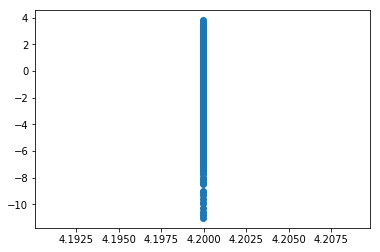

In [1095]:
training_predictions = NN_model.predict(X_train)
training = pd.DataFrame(training_predictions)
training['actual'] = y_train.reset_index()['rebounds']
plt.scatter(training_predictions,training[0]-training['actual'])

In [1096]:
predictions = NN_model.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

In [1097]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['rebounds']
testing['GBR_predictions']=gbr_predictions
testing['LY_rebounding']=X_test['rebounds_ly'].reset_index()['rebounds_ly']

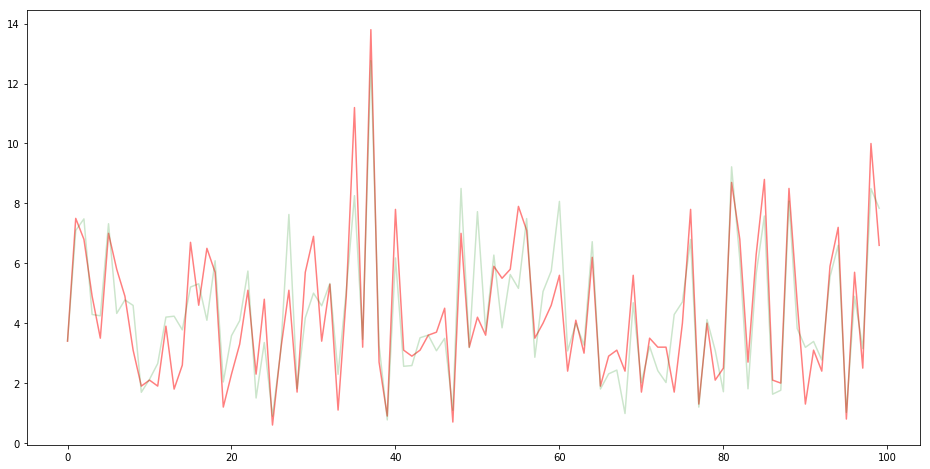

In [361]:
fig,ax = plt.subplots(figsize=(16,8))
plt.plot(testing[0:100].index,testing['actual'][0:100], color = 'r',alpha = 0.5)
plt.plot(testing[0:100].index,testing['NN_predictions'][0:100], color = 'g',alpha = 0.2)
#plt.scatter(testing[0:100].index,testing['LY_rebounding'][0:100],color = 'b',alpha=0.3)

In [1098]:
pred_2017rebounds = rebounds[rebounds['season']==2017].drop(['team','player','rebounds','Games'],axis=1)
rebounds_2017 = NN_model.predict(pred_2017rebounds)
test_2 =pd.DataFrame(rebounds_2017)
gbr_reb_2017 = pd.DataFrame(gbr.predict(pred_2017rebounds))
LR_reb_2017 = pd.DataFrame(LR.predict(pred_2017rebounds))
test_3 = pd.merge(rebounds,pred_2017rebounds,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_reb_2017[0]
test_3['LR_pred'] = LR_reb_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','rebounds','rebounds_ly_x','predictions','gbr_pred','LR_pred','mean_pred']].sort_values(by='rebounds_ly_x',ascending=False)[50:100]

rebounds_2017 = test_3[['player','LR_pred']]
rebounds_2017.columns = ['player','rebound_prediction']
df_2017 = pd.merge(df_2017,rebounds_2017, how='left',left_on='player',right_on='player')
#df_2017.drop(['rebound_prediction_x','rebound_prediction_y'])

In [ ]:
print('MSE using NN:{}'.format(np.mean((test_3['rebounds']-test_3['predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['rebounds']-np.mean(test_3['rebounds']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['rebounds']-test_3['rebounds_ly_x'])**2)))

In [1099]:
print('MSE using NN:{}'.format(np.mean((test_3['rebounds']-test_3['predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['rebounds']-np.mean(test_3['rebounds']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['rebounds']-test_3['rebounds_ly_x'])**2)))
print('MSE using gbr:{}'.format(np.mean((test_3['rebounds']-test_3['gbr_pred'])**2)))
print('MSE using LR:{}'.format(np.mean((test_3['rebounds']-test_3['LR_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['rebounds']-test_3['mean_pred'])**2)))

MSE using NN:6.310436734856431
MSE using mean:6.292553316074948
MSE using last year stats:1.808012820512822
MSE using gbr:1.3251446163562919
MSE using LR:1.2835836799139877
MSE using combo:1.8068446110195755


In [165]:
cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5)

array([0.8111346 , 0.75668588, 0.78079755, 0.72744262, 0.75121757])

In [1100]:
cross_val_score(LinearRegression(),X_train,y_train,cv=5)

array([0.81701435, 0.79285298, 0.81098242, 0.80524023, 0.80300007])

In [1101]:
'''next is assists'''


query= '''
        
        DROP TABLE IF EXISTS assists_pred;
        CREATE TABLE assists_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        ast float, -- these come from player_stats
        ast_ly float,
        change_ast_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        
        -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        assists_opened float,
        max_assistsdropped float,
        max_assistsadded float,
        points_opened float,
        threes_opened float,
        
        -- from player_advstats
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        ast_perc_ly float,
        change_assist_perc float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammateast float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_ast float,
        yearspro int
        );
        
        INSERT INTO assists_pred(season,player,age,team,ast,ast_ly,change_ast_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,ast,ast_ly,change_ast_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update assists_pred ap
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,assists_opened=tc.ast_opened,
        max_assistsdropped=tc.max_astdropped,max_assistsadded=tc.max_astadded,points_opened = tc.points_opened,threes_opened = tc.threes_opened
        from team_changes tc
        where tc.team = ap.team and ap.season=tc.season;
        
        update assists_pred ap
        set per_ly=pa.per_ly,change_per=pa.change_per,usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly
        ,ast_perc_ly = pa.ast_perc_ly,change_assist_perc = pa.change_assist_perc,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where ap.player = pa.player and ap.season = pa.season and ap.team = pa.startingteam;
        
        update assists_pred ap
        set max_teammateast = tm.max_teammateast,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = ap.season and tm.player = ap.player;
        
        update assists_pred ap
        set career_ast = pc.career_ast, yearspro = pc.yearspro
        from player_careerstats pc
        where ap.player = pc.player and ap.season = pc.season;
        
        
        select * from assists_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
assists_df = pd.DataFrame(np.array(data))
assists_df.columns = ['season','player','age','team','assists','assists_ly','change_assists_ly','Games','C_PF','PG','SG_SF','starter_change','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','assists_opened','max_assistsdropped',
                    'max_assistsadded','points_opened','threes_opened','per_ly','change_per','usagerank','usagerank_ly','ast_perc_ly','change_ast_perc','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement'
                      ,'max_teammateast','max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_assists','yearspro']

In [1102]:
assists_df['age_squared']=assists_df['age']*assists_df['age']
assists = assists_df[assists_df['assists_ly'].notna()]
for i in assists.columns:
    if i not in(['player','team']):
        assists[i]=pd.to_numeric(assists[i])
assists = assists.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1103]:
X = assists[(assists['season']!=2017) & (assists['Games']>30)].drop(['player','team','assists','Games'],axis=1)
y = assists[(assists['season']!=2017) & (assists['Games']>30)]['assists']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1106]:
NN_ast = Sequential()
NN_ast.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=1,activation='linear'))
NN_ast.compile(loss='mse', optimizer='adam')
NN_ast.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=64)

Epoch 1/1000
1564/1564 [==============================] - 4s 3ms/step - loss: 358414.0944
Epoch 2/1000
1564/1564 [==============================] - 0s 88us/step - loss: 105474.1111
Epoch 3/1000
1564/1564 [==============================] - 0s 85us/step - loss: 20594.1078
Epoch 4/1000
1564/1564 [==============================] - 0s 89us/step - loss: 2695.7679
Epoch 5/1000
1564/1564 [==============================] - 0s 87us/step - loss: 943.8340
Epoch 6/1000
1564/1564 [==============================] - 0s 85us/step - loss: 633.2143
Epoch 7/1000
1564/1564 [==============================] - 0s 82us/step - loss: 471.8396
Epoch 8/1000
1564/1564 [==============================] - 0s 81us/step - loss: 364.3458
Epoch 9/1000
1564/1564 [==============================] - 0s 93us/step - loss: 279.7499
Epoch 10/1000
1564/1564 [==============================] - 0s 87us/step - loss: 222.2310
Epoch 11/1000
1564/1564 [==============================] - 0s 89us/step - loss: 179.3289
Epoch 12/1000
1564/156

In [1107]:
predictions = NN_ast.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

In [1108]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['assists']
testing['GBR_predictions']=gbr_predictions
testing['LY_assists']=X_test['assists_ly'].reset_index()['assists_ly']
testing.sort_values(by='LY_assists',ascending=False)

,NN_predictions,actual,GBR_predictions,LY_assists
53,9.242417,10.7,9.917714,10.2
586,9.272506,9.1,8.959229,9.8
359,7.282634,8.2,7.756411,9.1
466,9.095310,9.7,9.223970,9.1
149,6.950994,9.6,7.516531,8.8
218,7.130557,7.4,6.941857,8.8
263,8.558582,10.0,8.314799,8.8
617,7.589120,7.0,6.409781,8.6
259,6.382652,7.9,6.455342,8.0
439,7.231490,7.6,7.523014,8.0


In [1109]:
pred_2017assists = assists[assists['season']==2017].drop(['team','player','assists','Games'],axis=1)
assists_2017 = NN_ast.predict(pred_2017assists)
gbr_ast_2017 = pd.DataFrame(gbr.predict(pred_2017assists))
LR_ast_2017 = pd.DataFrame(LR.predict(pred_2017assists))
test_2 =pd.DataFrame(assists_2017)
test_3 = pd.merge(assists,pred_2017assists,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_ast_2017[0]
test_3['LR_pred'] = LR_ast_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','assists','predictions','assists_ly_x','gbr_pred','LR_pred','mean_pred']].sort_values(by='assists_ly_x',ascending=False)[0:50]

assists_2017 = test_3[['player','LR_pred']]
assists_2017.columns = ['player','assist_prediction']
df_2017 = pd.merge(df_2017,assists_2017,how='left',left_on='player',right_on='player')

In [1110]:
print('MSE using NN:{}'.format(np.mean((test_3['assists']-test_3['predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['assists']-np.mean(test_3['assists']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['assists']-test_3['assists_ly_x'])**2)))
print('MSE using LR:{}'.format(np.mean((test_3['assists']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['assists']-test_3['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['assists']-test_3['mean_pred'])**2)))

MSE using NN:0.7667583732985284
MSE using mean:3.3617587113741045
MSE using last year stats:0.8503846153846144
MSE using LR:0.538446867619082
MSE using GB:0.5471953117768439
MSE using combo:0.565266482457822


In [1111]:
'''next is steals.  In the future, may want to add minutes from last season?'''


query= '''
        
        DROP TABLE IF EXISTS steals_pred;
        CREATE TABLE steals_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        stl float, -- these come from player_stats
        stl_ly float,
        change_stl_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        

        -- from player_advstats
        per_ly float,
        change_per float,
        stl_perc_ly float,
        change_stl_perc_ly float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_stl float,
        yearspro int
        );
        
        INSERT INTO steals_pred(season,player,age,team,stl,stl_ly,change_stl_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,stl,stl_ly,change_stl_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        
        update steals_pred sp
        set per_ly=pa.per_ly,change_per=pa.change_per,stl_perc_ly = pa.stl_perc_ly,change_stl_perc_ly = pa.change_stl_perc_ly
        ,defensive_winshares=pa.defensive_winshares,defensive_boxplusminus=pa.defensive_boxplusminus
        ,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where sp.player = pa.player and sp.season = pa.season and sp.team = pa.startingteam;
        
        update steals_pred sp
        set max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = sp.season and tm.player = sp.player;
        
        update steals_pred sp
        set career_stl = pc.career_stl, yearspro = pc.yearspro
        from player_careerstats pc
        where sp.player = pc.player and sp.season = pc.season;
        
        
        select * from steals_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
steals_df = pd.DataFrame(np.array(data))
steals_df.columns = ['season','player','age','team','steals','steals_ly','change_steals_ly','Games','C_PF','PG','SG_SF','starter_change'
                    ,'per_ly','change_per','stl_perc_ly','change_stl_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement'
                     ,'max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_steals','yearspro']

In [1112]:
steals_df['age_squared']=steals_df['age']*steals_df['age']
steals = steals_df[steals_df['steals_ly'].notna()]
for i in steals.columns:
    if i not in(['player','team']):
        steals[i]=pd.to_numeric(steals[i])
steals = steals.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1113]:
X = steals[(steals['season']!=2017) & (steals['Games']>30)].drop(['player','team','steals','Games'],axis=1)
y = steals[(steals['season']!=2017) & (steals['Games']>30)]['steals']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1115]:
NN_stl = Sequential()
NN_stl.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=1,activation='linear'))
NN_stl.compile(loss='mse', optimizer='adam')
NN_stl.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 5s 3ms/step - loss: 24624.2154
Epoch 2/1000
1564/1564 [==============================] - 0s 49us/step - loss: 4789.9030
Epoch 3/1000
1564/1564 [==============================] - 0s 49us/step - loss: 1004.2184
Epoch 4/1000
1564/1564 [==============================] - 0s 52us/step - loss: 454.3426
Epoch 5/1000
1564/1564 [==============================] - 0s 47us/step - loss: 287.6954
Epoch 6/1000
1564/1564 [==============================] - 0s 49us/step - loss: 202.4941
Epoch 7/1000
1564/1564 [==============================] - 0s 41us/step - loss: 149.0756
Epoch 8/1000
1564/1564 [==============================] - 0s 40us/step - loss: 110.9582
Epoch 9/1000
1564/1564 [==============================] - 0s 42us/step - loss: 82.8485
Epoch 10/1000
1564/1564 [==============================] - 0s 45us/step - loss: 61.8481
Epoch 11/1000
1564/1564 [==============================] - 0s 44us/step - loss: 46.2644
Epoch 12/1000
1564/1564 [=====

In [1116]:
predictions = NN_stl.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['steals']
testing['GBR_predictions']=gbr_predictions
testing['LY_steals']=X_test['steals_ly'].reset_index()['steals_ly']
testing.sort_values(by='LY_steals',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_steals
663,0.759017,1.7,1.353089,1.5
623,0.758752,1.6,1.173907,1.4
395,0.726249,1.3,1.239356,1.4
443,0.723091,1.9,1.440376,1.4
226,0.760643,1.1,1.266172,1.4
34,0.763718,1.5,1.390715,1.4
186,0.765402,1.1,1.319033,1.4
467,0.736633,1.6,1.673502,1.4
199,0.732376,1.0,0.962459,1.4
529,0.723670,1.2,1.422100,1.4


In [1117]:
pred_2017steals = steals[steals['season']==2017].drop(['team','player','steals','Games'],axis=1)
steals_2017 = NN_stl.predict(pred_2017steals)
gbr_stl_2017 = pd.DataFrame(gbr.predict(pred_2017steals))
LR_stl_2017 = pd.DataFrame(LR.predict(pred_2017steals))
test_2 =pd.DataFrame(steals_2017)
test_3 = pd.merge(steals,pred_2017steals,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_stl_2017[0]
test_3['LR_pred'] = LR_stl_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','steals','predictions','LR_pred','gbr_pred','mean_pred','steals_ly_x']].sort_values(by='steals_ly_x',ascending=False)[0:50]

steals_2017 = test_3[['player','LR_pred']]
steals_2017.columns = ['player','steal_prediction']
df_2017 = pd.merge(df_2017,steals_2017, how = 'left',left_on='player',right_on='player')

In [1118]:
print('MSE using LR:{}'.format(np.mean((test_3['steals']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['steals']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['steals']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['steals']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['steals']-np.mean(test_3['steals']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['steals']-test_3['steals_ly_x'])**2)))


MSE using LR:0.055367781036989874
MSE using GB:0.05970114369784547
MSE using NN:0.17131122692566111
MSE using combo:0.06922994157335643
MSE using mean:0.1709712976660093
MSE using last year stats:0.08067307692307696


In [401]:
print(gbr.feature_importances_)
X_train.columns

[0.01125328 0.04008531 0.10639288 0.04426043 0.02392808 0.00408012
 0.0016119  0.0723225  0.04320477 0.05824298 0.0763244  0.08581513
 0.04672878 0.07181035 0.06675481 0.04345141 0.15460267 0.01074619
 0.03838401]


Index(['season', 'age', 'steals_ly', 'change_steals_ly', 'C_PF', 'PG', 'SG_SF',
       'starter_change', 'per_ly', 'change_per', 'stl_perc_ly',
       'change_stl_perc', 'defensive_winshares', 'defensive_boxplusminus',
       'boxplusminus', 'value_overreplacement', 'career_steals', 'yearspro',
       'age_squared'],
      dtype='object')

In [1121]:
'''next is blocks.  In the future, may want to add minutes from last season?'''


query= '''
        
        DROP TABLE IF EXISTS blocks_pred;
        CREATE TABLE blocks_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        blk float, -- these come from player_stats
        blk_ly float,
        change_blk_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        

        -- from player_advstats
        per_ly float,
        change_per float,
        blk_perc_ly float,
        change_blk_perc_ly float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_blk float,
        yearspro int
        );
        
        INSERT INTO blocks_pred(season,player,age,team,blk,blk_ly,change_blk_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,blk,blk_ly,change_blk_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        
        update blocks_pred bp
        set per_ly=pa.per_ly,change_per=pa.change_per,blk_perc_ly = pa.blk_perc_ly,change_blk_perc_ly = pa.change_blk_perc_ly
        ,defensive_winshares=pa.defensive_winshares,defensive_boxplusminus=pa.defensive_boxplusminus
        ,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where bp.player = pa.player and bp.season = pa.season and bp.team = pa.startingteam;
        
        update blocks_pred bp
        set max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = bp.season and tm.player = bp.player;
        
        update blocks_pred bp
        set career_blk = pc.career_blk, yearspro = pc.yearspro
        from player_careerstats pc
        where bp.player = pc.player and bp.season = pc.season;
        
        
        select * from blocks_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
blocks_df = pd.DataFrame(np.array(data))
blocks_df.columns = ['season','player','age','team','blocks','blocks_ly','change_blocks_ly','Games','C_PF','PG','SG_SF','starter_change'
                    ,'per_ly','change_per','blk_perc_ly','change_blk_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement'
                     ,'max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_blocks','yearspro']

In [1122]:
blocks_df['age_squared']=blocks_df['age']*blocks_df['age']
blocks = blocks_df[blocks_df['blocks_ly'].notna()]
for i in blocks.columns:
    if i not in(['player','team']):
        blocks[i]=pd.to_numeric(blocks[i])
blocks = blocks.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1123]:
X = blocks[(blocks['season']!=2017) & (blocks['Games']>30)].drop(['player','team','blocks','Games'],axis=1)
#X = blocks[(blocks['season']!=2017) & (blocks['Games']>30)][['blocks_ly','career_blocks','starter_change']]
y = blocks[(blocks['season']!=2017) & (blocks['Games']>30)]['blocks']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1124]:
NN_blk = Sequential()
NN_blk.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=1,activation='linear'))
NN_blk.compile(loss='mse', optimizer='adam')
NN_blk.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 4s 2ms/step - loss: 701.7219
Epoch 2/1000
1564/1564 [==============================] - 0s 46us/step - loss: 137.8817
Epoch 3/1000
1564/1564 [==============================] - 0s 43us/step - loss: 51.9490
Epoch 4/1000
1564/1564 [==============================] - 0s 46us/step - loss: 24.8119
Epoch 5/1000
1564/1564 [==============================] - 0s 45us/step - loss: 8.7567
Epoch 6/1000
1564/1564 [==============================] - 0s 44us/step - loss: 6.4517
Epoch 7/1000
1564/1564 [==============================] - 0s 46us/step - loss: 4.8597
Epoch 8/1000
1564/1564 [==============================] - 0s 41us/step - loss: 3.8379
Epoch 9/1000
1564/1564 [==============================] - 0s 47us/step - loss: 3.4846
Epoch 10/1000
1564/1564 [==============================] - 0s 44us/step - loss: 2.9180
Epoch 11/1000
1564/1564 [==============================] - 0s 45us/step - loss: 2.4962
Epoch 12/1000
1564/1564 [======================

In [1125]:
predictions = NN_blk.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.3)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['blocks']
testing['GBR_predictions']=gbr_predictions
testing['LY_blocks']=X_test['blocks_ly'].reset_index()['blocks_ly']
testing.sort_values(by='LY_blocks',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_blocks
495,1.308844,1.5,1.308438,1.3
169,1.290654,0.7,1.227896,1.3
141,1.361557,1.5,1.371556,1.3
665,1.442019,0.9,1.280298,1.3
338,1.306439,0.7,1.000758,1.3
515,1.247858,0.8,1.118852,1.3
116,1.245815,1.6,1.082531,1.2
581,1.482907,1.0,1.131038,1.2
165,1.175403,1.0,0.970831,1.2
276,1.229028,0.8,1.102350,1.2


In [1126]:
pred_2017blocks = blocks[blocks['season']==2017].drop(['team','player','blocks','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
blocks_2017 = NN_blk.predict(pred_2017blocks)
gbr_blk_2017 = pd.DataFrame(gbr.predict(pred_2017blocks))
LR_blk_2017 = pd.DataFrame(LR.predict(pred_2017blocks))
test_2 =pd.DataFrame(blocks_2017)
test_3 = pd.merge(blocks,pred_2017blocks,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_blk_2017[0]
test_3['LR_pred'] = LR_blk_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','blocks','predictions','LR_pred','gbr_pred','mean_pred','blocks_ly_x']].sort_values(by='blocks_ly_x',ascending=False)[0:50]

blocks_2017 = test_3[['player','LR_pred']]
blocks_2017.columns=['player','block_predictions']
df_2017=pd.merge(df_2017,blocks_2017,how='left',left_on='player',right_on='player')


In [1127]:
print('MSE using LR:{}'.format(np.mean((test_3['blocks']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['blocks']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['blocks']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['blocks']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['blocks']-np.mean(test_3['blocks']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['blocks']-test_3['blocks_ly_x'])**2)))


MSE using LR:0.03740414863094713
MSE using GB:0.04271755093709498
MSE using NN:0.3406862582271147
MSE using combo:0.07015540109628207
MSE using mean:0.18036817882971723
MSE using last year stats:0.047980769230769105


In [1128]:
 query= '''
        
        DROP TABLE IF EXISTS threes_pred;
        CREATE TABLE threes_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        threes_made float, -- these come from player_stats
        threes_ly float,
        change_threes float,
        points_ly float,
        change_points_ly float,
        starter_change int,
        C_PF int,
        PG int,
        SG_SF int,
        Games int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        points_opened float,
        max_pointsdropped float,
        max_pointsadded float,
        
        three_ar_ly float, -- from player_advstats
        change_3ar float,
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammatepts float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_threes float,
        yearspro int
        );
        
        INSERT INTO threes_pred(season,player,age,team,threes_made,threes_ly,change_threes,points_ly,change_points_ly,starter_change,C_PF,PG,SG_SF,Games)
        SELECT season,player,age,startingteam,threes_made,threes_ly,change_threes,points_ly,change_points_ly,starter-starter_ly,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end,Games
        from player_stats;
        
        update threes_pred tp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,points_opened=tc.points_opened,
        max_pointsdropped=tc.max_pointsdropped,max_pointsadded=tc.max_pointsadded
        from team_changes tc
        where tc.team = tp.team and tp.season=tc.season;
        
        update threes_pred tp
        set three_ar_ly = pa.threear_ly,change_3ar=pa.change_3ar,per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where tp.player = pa.player and tp.season = pa.season and tp.team = pa.startingteam;
        
        update threes_pred tp
        set max_teammatepts = tm.max_teammatepts,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = tp.season and tm.player = tp.player;
        
        update threes_pred tp
        set career_threes = pc.career_threesmade, yearspro = pc.yearspro
        from player_careerstats pc
        where tp.player = pc.player and tp.season = pc.season;
        
        
        select * from threes_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
threes_df = pd.DataFrame(np.array(data))
threes_df.columns = ['season','player','age','team','3PM','3PM_ly','3PM_change','points_ly','change_points_ly','starter_change','C_PF','PG','SG_SF','Games','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','points_opened','max_pointsdropped',
                    'max_pointsadded','three_ar_ly','change_3ar','per_ly','change_per','usagerank','usagerank_ly','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement'
                     ,'max_teammatepts','max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_3PM','yearspro']

In [1129]:
threes_df['age_squared']=threes_df['age']*threes_df['age']
threes = threes_df[threes_df['3PM_ly'].notna()]
for i in threes.columns:
    if i not in(['player','team']):
        threes[i]=pd.to_numeric(threes[i])
threes = threes.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1130]:
X = threes[(threes['season']!=2017) & (threes['Games']>30)].drop(['player','team','3PM','Games'],axis=1)
y = threes[(threes['season']!=2017) & (threes['Games']>30)]['3PM']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1131]:
NN_3s = Sequential()
NN_3s.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_3s.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_3s.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_3s.add(Dense(units=1,activation='linear'))
NN_3s.compile(loss='mse', optimizer='adam')
NN_3s.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 4s 2ms/step - loss: 72872.4942
Epoch 2/1000
1564/1564 [==============================] - 0s 35us/step - loss: 17320.6356
Epoch 3/1000
1564/1564 [==============================] - 0s 36us/step - loss: 4186.0316
Epoch 4/1000
1564/1564 [==============================] - 0s 44us/step - loss: 1350.9023
Epoch 5/1000
1564/1564 [==============================] - 0s 37us/step - loss: 484.4683
Epoch 6/1000
1564/1564 [==============================] - 0s 43us/step - loss: 183.2796
Epoch 7/1000
1564/1564 [==============================] - 0s 42us/step - loss: 68.5733
Epoch 8/1000
1564/1564 [==============================] - 0s 42us/step - loss: 44.1678
Epoch 9/1000
1564/1564 [==============================] - 0s 50us/step - loss: 34.4818
Epoch 10/1000
1564/1564 [==============================] - 0s 48us/step - loss: 29.8169
Epoch 11/1000
1564/1564 [==============================] - 0s 42us/step - loss: 26.7103
Epoch 12/1000
1564/1564 [=====

In [1132]:
predictions = NN_3s.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['3PM']
testing['GBR_predictions']=gbr_predictions
testing['LY_3PM']=X_test['3PM_ly'].reset_index()['3PM_ly']
testing.sort_values(by='LY_3PM',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_3PM
668,1.167616,1.5,1.541947,1.7
9,1.218016,1.3,1.575233,1.7
115,1.158675,2.0,1.338188,1.7
240,1.409895,2.1,1.665877,1.7
444,1.055502,1.0,1.322050,1.7
231,1.142844,1.3,1.335763,1.7
568,1.386260,0.7,1.814882,1.7
340,1.194769,2.2,1.640906,1.7
133,1.356005,1.4,1.493987,1.7
251,1.339873,1.4,1.469463,1.7


In [1133]:
pred_2017threes = threes[threes['season']==2017].drop(['team','player','3PM','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
threes_2017 = NN_3s.predict(pred_2017threes)
gbr_3PM_2017 = pd.DataFrame(gbr.predict(pred_2017threes))
LR_3PM_2017 = pd.DataFrame(LR.predict(pred_2017threes))
test_2 =pd.DataFrame(threes_2017)
test_3 = pd.merge(threes,pred_2017threes,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_3PM_2017[0]
test_3['LR_pred'] = LR_3PM_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','3PM','predictions','LR_pred','gbr_pred','mean_pred','3PM_ly_x']].sort_values(by='3PM_ly_x',ascending=False)[0:50]

threes_2017 = test_3[['player','LR_pred']]
threes_2017.columns = ['player','three_prediction']
df_2017 = pd.merge(df_2017,threes_2017,how='left',left_on='player',right_on='player')

In [1134]:
print('MSE using LR:{}'.format(np.mean((test_3['3PM']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['3PM']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['3PM']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['3PM']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['3PM']-np.mean(test_3['3PM']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['3PM']-test_3['3PM_ly_x'])**2)))

MSE using LR:0.162525600754578
MSE using GB:0.16707504733095485
MSE using NN:0.4381243096569014
MSE using combo:0.20121757820849856
MSE using mean:0.7179477933925056
MSE using last year stats:0.2091987179487179


In [1135]:
query= '''
        
        DROP TABLE IF EXISTS turnovers_pred;
        CREATE TABLE turnovers_pred(
        season int, -- these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        turnovers float, 
        turnovers_ly float,
        change_tov_ly float,
        starter_change int,
        Games int,
        C_PF int,
        PG int,
        SG_SF int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        
        max_teammatepts float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_to float,
        yearspro int
        );
        
        INSERT INTO turnovers_pred(season,player,age,team,turnovers,turnovers_ly,change_tov_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,tov,tov_ly,change_tov_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update turnovers_pred pp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped
        from team_changes tc
        where tc.team = pp.team and pp.season=tc.season;
        
        update turnovers_pred pp
        set per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus
        from player_advstats pa
        where pp.player = pa.player and pp.season = pa.season and pp.team = pa.startingteam;
        
        update turnovers_pred pp
        set max_teammatepts = tm.max_teammatepts,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = pp.season and tm.player = pp.player;
        
        update turnovers_pred pp
        set career_to = pc.career_to, yearspro = pc.yearspro
        from player_careerstats pc
        where pp.player = pc.player and pp.season = pc.season;
        
        
        select * from turnovers_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
to_df = pd.DataFrame(np.array(data))
to_df.columns = ['season','player','age','team','turnovers','turnovers_ly','change_turnovers_ly','starter_change','Games','C_PF','PG','SG_SF','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped'
                    ,'per_ly','change_per','usagerank','usagerank_ly','offensive_winshares','offensive_boxplusminus'
                 ,'max_teammatepts','max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_turnovers','yearspro']

In [1136]:
to_df['age_squared']=to_df['age']*to_df['age']
tos = to_df[to_df['turnovers_ly'].notna()]
for i in tos.columns:
    if i not in(['player','team']):
        tos[i]=pd.to_numeric(tos[i])
tos = tos.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1137]:
X = tos[(tos['season']!=2017) & (tos['Games']>30)].drop(['player','team','turnovers','Games'],axis=1)
y = tos[(tos['season']!=2017) & (tos['Games']>30)]['turnovers']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1138]:
NN_tos = Sequential()
NN_tos.add(Dense(units=8,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_tos.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
#NN_tos.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_tos.add(Dense(units=1,activation='linear'))
NN_tos.compile(loss='mse', optimizer='adam')
NN_tos.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 4s 2ms/step - loss: 56531.3866
Epoch 2/1000
1564/1564 [==============================] - 0s 44us/step - loss: 22807.0294
Epoch 3/1000
1564/1564 [==============================] - 0s 42us/step - loss: 15772.3369
Epoch 4/1000
1564/1564 [==============================] - 0s 45us/step - loss: 13331.3271
Epoch 5/1000
1564/1564 [==============================] - 0s 44us/step - loss: 10276.0411
Epoch 6/1000
1564/1564 [==============================] - 0s 46us/step - loss: 7515.8865
Epoch 7/1000
1564/1564 [==============================] - 0s 45us/step - loss: 5619.0386
Epoch 8/1000
1564/1564 [==============================] - 0s 45us/step - loss: 4187.4759
Epoch 9/1000
1564/1564 [==============================] - 0s 44us/step - loss: 3199.9343
Epoch 10/1000
1564/1564 [==============================] - 0s 45us/step - loss: 2534.0292
Epoch 11/1000
1564/1564 [==============================] - 0s 40us/step - loss: 1975.2809
Epoch 12/1000
1

In [1139]:
predictions = NN_tos.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['turnovers']
testing['GBR_predictions']=gbr_predictions
testing['LY_turnovers']=X_test['turnovers_ly'].reset_index()['turnovers_ly']
testing.sort_values(by='LY_turnovers',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_turnovers
264,1.480142,2.2,2.223566,2.6
450,1.720437,1.8,1.965623,2.6
162,1.208963,2.3,2.586961,2.5
620,2.748666,3.2,2.348369,2.5
565,2.366769,1.4,2.195694,2.5
619,1.286111,2.5,2.220980,2.5
605,1.417581,2.9,2.478078,2.5
79,1.741372,3.0,2.311394,2.5
548,2.416848,3.0,2.102031,2.5
386,1.267160,1.9,2.068748,2.5


In [1140]:
pred_2017tos = tos[tos['season']==2017].drop(['team','player','turnovers','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
tos_2017 = NN_tos.predict(pred_2017tos)
gbr_tos_2017 = pd.DataFrame(gbr.predict(pred_2017tos))
LR_tos_2017 = pd.DataFrame(LR.predict(pred_2017tos))
test_2 =pd.DataFrame(tos_2017)
test_3 = pd.merge(tos,pred_2017tos,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_tos_2017[0]
test_3['LR_pred'] = LR_tos_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','turnovers','predictions','LR_pred','gbr_pred','mean_pred','turnovers_ly_x']].sort_values(by='turnovers_ly_x',ascending=False)[0:50]

to_2017 = test_3[['player','LR_pred']]
to_2017.columns = ['player','turnover_prediction']
df_2017 = pd.merge(df_2017,to_2017,how='left',left_on='player',right_on='player')

In [1141]:
print('MSE using LR:{}'.format(np.mean((test_3['turnovers']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['turnovers']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['turnovers']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['turnovers']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['turnovers']-np.mean(test_3['turnovers']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['turnovers']-test_3['turnovers_ly_x'])**2)))

MSE using LR:0.15807940879934615
MSE using GB:0.14868131059397866
MSE using NN:2.00328677909116
MSE using combo:0.37595236256225756
MSE using mean:0.6552399737015094
MSE using last year stats:0.210833333333333


In [1143]:
 query= '''
        
        DROP TABLE IF EXISTS percentages;
        CREATE TABLE percentages(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        FGM float, -- these come from player_stats
        FGA float,
        FG_percent float,
        FG_percent_ly float,
        FGM_ly float,
        FGA_ly float,
        FTM float,
        FTA float,
        FT_percent float,
        FT_percent_ly float,
        FTM_ly float,
        FTA_ly float,
        threes_ly float,
        change_threes float,
        points_ly float,
        change_points_ly float,
        starter_change int,
        C_PF int,
        PG int,
        SG_SF int,
        Games int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        points_opened float,
        max_pointsdropped float,
        max_pointsadded float,
        
        three_ar_ly float, -- from player_advstats
        change_3ar float,
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammatepts float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        
        career_FGM float,
        career_FGA float,
        career_FGPercent float,
        career_FTM float,
        career_FTA float,
        career_FTPercent float,
        yearspro int
        );
        
        INSERT INTO percentages(season,player,age,team,FGM,FGA,FG_percent,FG_percent_ly,FGM_ly,FGA_ly,FTM,FTA,FT_percent
        ,FT_percent_ly,FTM_ly,FTA_ly,threes_ly,change_threes,points_ly,change_points_ly,starter_change,C_PF,PG,SG_SF,Games)
        SELECT season,player,age,startingteam,FG,FGA,case when FGA>0 then FG/FGA else 0 end as FG_percent,
        case when fga_ly>0 then fg_ly/fga_ly else 0 end as FG_percent_ly,FG_ly,fga_ly,FTM,FTA,
        case when FTA>0 then FTM/FTA else 0 end, case when fta_ly>0 then FTM_ly/FTA_ly else 0 end, FTM_ly,FTA_ly,
        threes_ly,change_threes,points_ly,change_points_ly,starter-starter_ly,case when pos in ('C','PF') then 1 else 0 end,
        case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end,Games
        from player_stats;
        
        update percentages tp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,points_opened=tc.points_opened,
        max_pointsdropped=tc.max_pointsdropped,max_pointsadded=tc.max_pointsadded
        from team_changes tc
        where tc.team = tp.team and tp.season=tc.season;
        
        update percentages tp
        set three_ar_ly = pa.threear_ly,change_3ar=pa.change_3ar,per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where tp.player = pa.player and tp.season = pa.season and tp.team = pa.startingteam;
        
        update percentages tp
        set max_teammatepts = tm.max_teammatepts,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = tp.season and tm.player = tp.player;
        
        update percentages tp
        set career_fgm = pc.career_fgm,career_fga = pc.career_fga,career_FGpercent = case when pc.career_FGA>0 then pc.career_FGM/pc.career_FGA else 0 end,
        career_FTM = pc.career_FTM,career_FTA = pc.career_FTA,career_FTPercent = case when pc.career_FTA>0 then pc.career_FTM/pc.career_FTA else 0 end,yearspro = pc.yearspro
        from player_careerstats pc
        where tp.player = pc.player and tp.season = pc.season;
        
        
        select * from percentages where season>2009
        '''

cur.execute(query)
data = cur.fetchall()
percentages_df = pd.DataFrame(np.array(data))
percentages_df.columns = ['season','player','age','team','FGM','FGA','FG_percent','FG_percent_ly','FGM_ly','FGA_ly','FTM','FTA',
                     'FT_percent','FT_percent_ly','FTM_ly','FTA_ly','3PM_ly','3PM_change','points_ly','change_points_ly','starter_change'
                     ,'C_PF','PG','SG_SF','Games','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped'
                     ,'points_opened','max_pointsdropped','max_pointsadded','three_ar_ly','change_3ar','per_ly','change_per','usagerank','usagerank_ly'
                     ,'offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement'
                    ,'max_teammatepts','max_teammate_usage','max_teammateto','max_teammateshot_attempts'
                    ,'career_FGM','career_FGA','career_FGpercent','career_FTM','career_FTA','career_FTPercent','yearspro']

In [1144]:
percentages_df['age_squared']=percentages_df['age']*percentages_df['age']
percentages = percentages_df[percentages_df['FGM_ly'].notna()]
for i in percentages.columns:
    if i not in(['player','team']):
        percentages[i]=pd.to_numeric(percentages[i])
percentages = percentages.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [1145]:
X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
y = percentages[(percentages['season']!=2017) & (percentages['Games']>30)]['FGM']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1146]:
NN_FGM = Sequential()
NN_FGM.add(Dense(units=32,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGM.add(Dense(units=16, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGM.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGM.add(Dense(units=1,activation='linear'))
NN_FGM.compile(loss='mse', optimizer='adam')
NN_FGM.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 4s 3ms/step - loss: 64814.1612
Epoch 2/1000
1564/1564 [==============================] - 0s 52us/step - loss: 5777.8563
Epoch 3/1000
1564/1564 [==============================] - 0s 45us/step - loss: 1801.2294
Epoch 4/1000
1564/1564 [==============================] - 0s 49us/step - loss: 839.9773
Epoch 5/1000
1564/1564 [==============================] - 0s 47us/step - loss: 319.6998
Epoch 6/1000
1564/1564 [==============================] - 0s 47us/step - loss: 193.0979
Epoch 7/1000
1564/1564 [==============================] - 0s 49us/step - loss: 144.3669
Epoch 8/1000
1564/1564 [==============================] - 0s 48us/step - loss: 118.0004
Epoch 9/1000
1564/1564 [==============================] - 0s 46us/step - loss: 99.0409
Epoch 10/1000
1564/1564 [==============================] - 0s 48us/step - loss: 83.2343
Epoch 11/1000
1564/1564 [==============================] - 0s 48us/step - loss: 70.2887
Epoch 12/1000
1564/1564 [=====

In [1147]:
predictions = NN_FGM.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['FGM']
testing['GBR_predictions']=gbr_predictions
testing['LY_FGM']=X_test['FGM_ly'].reset_index()['FGM_ly']
testing.sort_values(by='LY_FGM',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_FGM
62,5.775374,7.1,6.914423,7.0
216,5.086746,4.6,4.675457,6.9
168,6.337204,6.5,6.284716,6.8
377,6.063814,5.5,6.152646,6.8
581,5.208510,7.7,5.754109,6.8
95,6.016421,8.1,6.357587,6.8
591,5.589433,6.9,5.968942,6.8
221,6.138728,7.4,6.290253,6.7
119,6.552523,6.7,6.245836,6.7
442,6.352209,7.4,6.298005,6.7


In [1148]:
pred_2017FGM = percentages[percentages['season']==2017].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
FGM_2017 = NN_FGM.predict(pred_2017FGM)
gbr_FGM_2017 = pd.DataFrame(gbr.predict(pred_2017FGM))
LR_FGM_2017 = pd.DataFrame(LR.predict(pred_2017FGM))
test_2 =pd.DataFrame(FGM_2017)
test_3 = pd.merge(percentages,pred_2017FGM,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_FGM_2017[0]
test_3['LR_pred'] = LR_FGM_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','FGM','predictions','LR_pred','gbr_pred','mean_pred','FGM_ly_x']].sort_values(by='FGM_ly_x',ascending=False)[0:50]

FGM_2017 = test_3[['player','LR_pred']]
FGM_2017.columns = ['player','FGM_prediction']
df_2017 = pd.merge(df_2017,FGM_2017, how='left',left_on='player',right_on='player')


In [1149]:
print('MSE using LR:{}'.format(np.mean((test_3['FGM']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['FGM']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['FGM']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['FGM']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['FGM']-np.mean(test_3['FGM']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['FGM']-test_3['FGM_ly_x'])**2)))

MSE using LR:0.9791658845717702
MSE using GB:0.9344283542953499
MSE using NN:1.4054807170667343
MSE using combo:1.0068003976298765
MSE using mean:4.2722633136094625
MSE using last year stats:1.5276602564102566


In [508]:
percentages.columns

Index(['season', 'player', 'age', 'team', 'FGM', 'FGA', 'FG_percent',
       'FG_percent_ly', 'FGM_ly', 'FGA_ly', 'FTM', 'FTA', 'FT_percent',
       'FT_percent_ly', 'FTM_ly', 'FTA_ly', '3PM_ly', '3PM_change',
       'points_ly', 'change_points_ly', 'starter_change', 'C_PF', 'PG',
       'SG_SF', 'Games', 'high_usageplayer_added', 'usagemin_opened',
       'maxusage_added', 'high_usageplayer_dropped', 'points_opened',
       'max_pointsdropped', 'max_pointsadded', 'three_ar_ly', 'change_3ar',
       'per_ly', 'change_per', 'usagerank', 'usagerank_ly',
       'offensive_winshares', 'offensive_boxplusminus', 'boxplusminus',
       'value_overreplacement', 'career_FGM', 'career_FGA', 'career_FGpercent',
       'career_FTM', 'career_FTA', 'career_FTPercent', 'yearspro'],
      dtype='object')

In [1150]:
#X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)][['FG_percent_ly','career_FGpercent','age','age_squared','yearspro']]
y = percentages[(percentages['season']!=2017) & (percentages['Games']>30)]['FG_percent']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1151]:
NN_FGP = Sequential()
NN_FGP.add(Dense(units=4,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGP.add(Dense(units=2, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
#NN_FGP.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGP.add(Dense(units=1,activation='linear'))
NN_FGP.compile(loss='mse', optimizer='adam')
NN_FGP.fit(np.array(X_train), np.array(y_train), epochs=100,batch_size=64)


Epoch 1/100
1564/1564 [==============================] - 4s 3ms/step - loss: 0.1995
Epoch 2/100
1564/1564 [==============================] - 0s 85us/step - loss: 0.1782
Epoch 3/100
1564/1564 [==============================] - 0s 86us/step - loss: 0.1586
Epoch 4/100
1564/1564 [==============================] - 0s 91us/step - loss: 0.1408
Epoch 5/100
1564/1564 [==============================] - 0s 88us/step - loss: 0.1245
Epoch 6/100
1564/1564 [==============================] - 0s 87us/step - loss: 0.1098
Epoch 7/100
1564/1564 [==============================] - 0s 88us/step - loss: 0.0965
Epoch 8/100
1564/1564 [==============================] - 0s 81us/step - loss: 0.0845
Epoch 9/100
1564/1564 [==============================] - 0s 73us/step - loss: 0.0738
Epoch 10/100
1564/1564 [==============================] - 0s 62us/step - loss: 0.0643
Epoch 11/100
1564/1564 [==============================] - 0s 63us/step - loss: 0.0558
Epoch 12/100
1564/1564 [==============================] - 0s 84u

In [1152]:
predictions = NN_FGP.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['FG_percent']
testing['GBR_predictions']=gbr_predictions
testing['LY_FGP']=X_test['FG_percent_ly'].reset_index()['FG_percent_ly']
testing.sort_values(by='LY_FGP',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_FGP
658,0.454044,0.510204,0.540335,0.543689
318,0.454044,0.610169,0.542324,0.543478
201,0.454044,0.489583,0.571376,0.543210
452,0.454044,0.450000,0.546024,0.542857
397,0.454044,0.527473,0.528416,0.542553
282,0.454044,0.530769,0.520532,0.540230
533,0.454044,0.533333,0.532005,0.540000
143,0.454044,0.557692,0.509531,0.538462
349,0.454044,0.525547,0.525501,0.538462
225,0.454044,0.424528,0.518157,0.538462


In [1153]:
pred_2017FGP = percentages[percentages['season']==2017][['FG_percent_ly','career_FGpercent','age','age_squared','yearspro']]
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
FGP_2017 = NN_FGP.predict(pred_2017FGP)
gbr_FGP_2017 = pd.DataFrame(gbr.predict(pred_2017FGP))
LR_FGP_2017 = pd.DataFrame(LR.predict(pred_2017FGP))
test_2 =pd.DataFrame(FGP_2017)
test_3 = pd.merge(percentages,pred_2017FGP,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_FGP_2017[0]
test_3['LR_pred'] = LR_FGP_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','FG_percent','predictions','LR_pred','gbr_pred','mean_pred','FG_percent_ly_x']].sort_values(by='FG_percent_ly_x',ascending=False)[0:50]

FGP_2017 = test_3[['player','LR_pred']]
FGP_2017.columns = ['player','FGP_prediction']
df_2017 = pd.merge(df_2017,FGP_2017,how='left',left_on='player',right_on='player')


In [1154]:
df_2017['FGA_prediction']=df_2017['FGM_prediction']/df_2017['FGP_prediction']
df_2017

,season,player,position,age,team,gamesPlayed,gamesStarted,minutes,points,rebounds,...,point_prediction1,rebound_prediction,assist_prediction,steal_prediction,block_predictions,three_prediction,turnover_prediction,FGM_prediction,FGP_prediction,FGA_prediction
0,2017,LeBron James,PF,33,CLE,82,82,36.9,27.5,8.6,...,24.870920,8.404722,8.170845,1.345292,0.612607,1.647424,3.552995,9.330926,0.505386,18.462954
1,2017,Khris Middleton,SF,26,MIL,82,82,36.4,20.1,5.2,...,13.640875,3.901478,2.844345,1.227558,0.166228,1.536074,1.818488,4.960662,0.451003,10.999172
2,2017,Bradley Beal,SG,24,WAS,82,82,36.3,22.6,4.4,...,21.028357,3.640051,3.421147,1.077844,0.303437,2.646208,2.034305,7.402198,0.460459,16.075688
3,2017,Andrew Wiggins,SF,22,MIN,82,82,36.3,17.7,4.4,...,20.456723,3.821239,2.183822,0.951058,0.449024,1.230865,2.170531,7.529388,0.461304,16.321960
4,2017,CJ McCollum,SG,26,POR,81,81,36.1,21.4,4.0,...,20.253920,3.537566,3.537808,0.920871,0.399520,2.248571,2.156241,7.565362,0.461679,16.386628
5,2017,Jrue Holiday,SG,27,NOP,81,81,36.1,19.0,4.5,...,13.656572,3.484355,5.860924,1.326976,0.524537,1.430401,2.249917,5.137229,0.447882,11.470059
6,2017,Karl-Anthony Towns,C,22,MIN,82,82,35.6,21.3,12.3,...,23.705239,11.656341,3.322843,0.888906,1.328844,1.251075,2.640501,9.765563,0.530322,18.414395
7,2017,Russell Westbrook,PG,29,OKC,80,80,36.4,25.4,10.1,...,28.462095,10.150878,10.620148,1.909999,0.370554,2.378485,4.366154,9.433284,0.434506,21.710369
8,2017,Paul George,SF,27,OKC,79,79,36.6,21.9,5.7,...,20.803492,6.384050,3.355529,1.493419,0.386995,2.441891,2.448160,7.033615,0.442657,15.889551
9,2017,Giannis Antetokounmpo,PF,23,MIL,75,75,36.7,26.9,10.0,...,22.212587,9.356313,5.376734,1.473798,1.590362,0.983095,2.786507,8.368180,0.500216,16.729118


In [1155]:
print('MSE using LR:{}'.format(np.mean((test_3['FG_percent']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['FG_percent']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['FG_percent']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['FG_percent']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['FG_percent']-np.mean(test_3['FG_percent']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['FG_percent']-test_3['FG_percent_ly_x'])**2)))

MSE using LR:0.00220035043182581
MSE using GB:0.002230171251758615
MSE using NN:0.004654242109894819
MSE using combo:0.002452064257550974
MSE using mean:0.004468180392374211
MSE using last year stats:0.0029957528880071352


In [1156]:
X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
y = percentages[(percentages['season']!=2017) & (percentages['Games']>30)]['FTM']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1157]:
NN_FTM = Sequential()
NN_FTM.add(Dense(units=32,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTM.add(Dense(units=16, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTM.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTM.add(Dense(units=1,activation='linear'))
NN_FTM.compile(loss='mse', optimizer='adam')
NN_FTM.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/10
1564/1564 [==============================] - 4s 3ms/step - loss: 380.5611
Epoch 2/10
1564/1564 [==============================] - 0s 50us/step - loss: 129.7028
Epoch 3/10
1564/1564 [==============================] - 0s 47us/step - loss: 62.3981
Epoch 4/10
1564/1564 [==============================] - 0s 47us/step - loss: 35.4176
Epoch 5/10
1564/1564 [==============================] - 0s 49us/step - loss: 22.3636
Epoch 6/10
1564/1564 [==============================] - 0s 47us/step - loss: 13.4869
Epoch 7/10
1564/1564 [==============================] - 0s 46us/step - loss: 8.7304
Epoch 8/10
1564/1564 [==============================] - 0s 47us/step - loss: 6.0450
Epoch 9/10
1564/1564 [==============================] - 0s 49us/step - loss: 4.6568
Epoch 10/10
1564/1564 [==============================] - 0s 52us/step - loss: 3.9467


In [1158]:
predictions = NN_FTM.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['FTM']
testing['GBR_predictions']=gbr_predictions
testing['LY_FTM']=X_test['FTM_ly'].reset_index()['FTM_ly']
testing.sort_values(by='LY_FTM',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_FTM
513,2.987642,1.9,3.862760,4.2
523,-0.546500,3.5,3.730544,4.0
492,1.268108,4.3,4.279532,4.0
31,3.036972,2.8,3.419854,4.0
275,2.156424,3.8,4.440988,3.9
358,3.378700,3.1,3.834485,3.9
188,1.816694,3.5,3.889511,3.9
110,0.345463,3.3,3.761153,3.8
216,0.589378,3.1,3.218305,3.8
71,0.682622,3.6,3.874601,3.8


In [1159]:
pred_2017FTM = percentages[percentages['season']==2017].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
FTM_2017 = NN_FTM.predict(pred_2017FTM)
gbr_FTM_2017 = pd.DataFrame(gbr.predict(pred_2017FTM))
LR_FTM_2017 = pd.DataFrame(LR.predict(pred_2017FTM))
test_2 =pd.DataFrame(FTM_2017)
test_3 = pd.merge(percentages,pred_2017FTM,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_FTM_2017[0]
test_3['LR_pred'] = LR_FTM_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','FTM','predictions','LR_pred','gbr_pred','mean_pred','FTM_ly_x']].sort_values(by='FTM_ly_x',ascending=False)[0:50]

FTM_2017 = test_3[['player','LR_pred']]
FTM_2017.columns=['player','FTM_predictions']
df_2017 = pd.merge(df_2017,FTM_2017,how='left',left_on='player',right_on='player')

In [1160]:
print('MSE using LR:{}'.format(np.mean((test_3['FTM']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['FTM']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['FTM']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['FTM']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['FTM']-np.mean(test_3['FTM']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['FTM']-test_3['FTM_ly_x'])**2)))

MSE using LR:0.42001895430317404
MSE using GB:0.37678979516194644
MSE using NN:3.351381637518095
MSE using combo:0.6675173816778073
MSE using mean:1.8538198553583185
MSE using last year stats:0.6499358974358973


In [1161]:
X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)][['FT_percent_ly','career_FTPercent','yearspro']]
y = percentages[(percentages['season']!=2017) & (percentages['Games']>30)]['FT_percent']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [1162]:
NN_FTP = Sequential()
NN_FTP.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTP.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
#NN_FTP.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTP.add(Dense(units=1,activation='linear'))
NN_FTP.compile(loss='mse', optimizer='adam')
NN_FTP.fit(np.array(X_train), np.array(y_train), epochs=250,batch_size=64)

Epoch 1/25
1564/1564 [==============================] - 4s 3ms/step - loss: 0.1908
Epoch 2/25
1564/1564 [==============================] - 0s 90us/step - loss: 0.0657
Epoch 3/25
1564/1564 [==============================] - 0s 86us/step - loss: 0.0343
Epoch 4/25
1564/1564 [==============================] - 0s 87us/step - loss: 0.0193
Epoch 5/25
1564/1564 [==============================] - 0s 93us/step - loss: 0.0141
Epoch 6/25
1564/1564 [==============================] - 0s 90us/step - loss: 0.0128
Epoch 7/25
1564/1564 [==============================] - 0s 86us/step - loss: 0.0125
Epoch 8/25
1564/1564 [==============================] - 0s 86us/step - loss: 0.0124
Epoch 9/25
1564/1564 [==============================] - 0s 89us/step - loss: 0.0123
Epoch 10/25
1564/1564 [==============================] - 0s 89us/step - loss: 0.0123
Epoch 11/25
1564/1564 [==============================] - 0s 86us/step - loss: 0.0122
Epoch 12/25
1564/1564 [==============================] - 0s 90us/step - los

In [1163]:
predictions = NN_FTP.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['FT_percent']
testing['GBR_predictions']=gbr_predictions
testing['LY_FT_percent']=X_test['FT_percent_ly'].reset_index()['FT_percent_ly']
testing.sort_values(by='LY_FT_percent',ascending=False)[50:100]

,NN_predictions,actual,GBR_predictions,LY_FT_percent
643,0.764008,0.666667,0.767697,0.882353
593,0.827853,0.791667,0.857396,0.882353
425,0.841047,0.888889,0.868265,0.880952
274,0.835460,0.846154,0.869945,0.880000
250,0.796701,0.841270,0.840606,0.877551
459,0.803810,0.875000,0.836172,0.875000
31,0.821201,0.833333,0.834139,0.875000
299,0.790426,0.850000,0.819617,0.875000
414,0.806977,0.857143,0.863934,0.875000
158,0.817473,0.733333,0.827993,0.875000


In [1164]:
pred_2017FTP = percentages[percentages['season']==2017][['FT_percent_ly','career_FTPercent','yearspro']]
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
FTP_2017 = NN_FTP.predict(pred_2017FTP)
gbr_FTP_2017 = pd.DataFrame(gbr.predict(pred_2017FTP))
LR_FTP_2017 = pd.DataFrame(LR.predict(pred_2017FTP))
test_2 =pd.DataFrame(FTP_2017)
test_3 = pd.merge(percentages,pred_2017FTP,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_FTP_2017[0]
test_3['LR_pred'] = LR_FTP_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','FT_percent','predictions','LR_pred','gbr_pred','mean_pred','FT_percent_ly_x']].sort_values(by='FT_percent_ly_x',ascending=False)[0:50]

FTP_2017 = test_3[['player','LR_pred']]
FTP_2017.columns=['player','FTP_prediction']
df_2017 = pd.merge(df_2017,FTP_2017,how='left',left_on='player',right_on='player')

In [1165]:
df_2017['FTA_prediction'] = df_2017['FTM_predictions']/df_2017['FTP_prediction']

In [1166]:
print('MSE using LR:{}'.format(np.mean((test_3['FT_percent']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['FT_percent']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['FT_percent']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['FT_percent']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['FT_percent']-np.mean(test_3['FT_percent']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['FT_percent']-test_3['FT_percent_ly_x'])**2)))

MSE using LR:0.007194073407913135
MSE using GB:0.010545246179434935
MSE using NN:0.008063088036505553
MSE using combo:0.0073847984682895
MSE using mean:0.012220424699955452
MSE using last year stats:0.01047733460460316


In [ ]:
cur.close()
conn.close

In [1014]:
df_2017.columns

Index(['season', 'player', 'position', 'age', 'team', 'gamesPlayed',
       'gamesStarted', 'minutes', 'points', 'rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'threes_made', 'FGM', 'FGA', 'FTM', 'FTA',
       'starter', 'min_rank', 'point_prediction1', 'rebound_prediction',
       'assist_prediction', 'steal_prediction', 'block_predictions',
       'three_prediction', 'turnover_prediction', 'FGM_prediction',
       'FGP_prediction', 'FGA_prediction', 'FTM_predictions', 'FTP_prediction',
       'FTA_prediction'],
      dtype='object')

In [1168]:
df_2017['point_prediction2'] = (df_2017['FGM_prediction']*2)+df_2017['FTM_predictions']+df_2017['three_prediction']

In [1169]:
prediction_ranker = df_2017[df_2017['point_prediction2'].notna()][['season','player','point_prediction2','rebound_prediction','assist_prediction','steal_prediction','block_predictions','turnover_prediction','three_prediction','FGM_prediction','FGA_prediction','FTM_predictions','FTA_prediction','min_rank']]
prediction_ranker.columns=['season','player','points','rebounds','assists','steals','blocks','turnovers','threes_made','FGM','FGA','FTM','FTA','min_rank']

In [1173]:
test_2017 = Player_ranker(prediction_ranker)

In [1174]:
test_2017.get_category_dist()
test_2017.assign_values()

In [1211]:
prediction_ranker2 = test_2017.value.sort_values(by='value_tot',ascending=False).reset_index(drop=True).reset_index()
prediction_ranker2['predicted_rank'] = prediction_ranker2['index']+1
prediction_ranker2.drop('index',axis=1,inplace=True)

In [1214]:
prediction_ranker[0:50]

,season,player,points,rebounds,assists,steals,blocks,turnovers,threes_made,FGM,FGA,FTM,FTA,min_rank
0,2017,LeBron James,24.943032,8.404722,8.170845,1.345292,0.612607,3.552995,1.647424,9.330926,18.462954,4.633756,6.224230,1
1,2017,Khris Middleton,13.992393,3.901478,2.844345,1.227558,0.166228,1.818488,1.536074,4.960662,10.999172,2.534996,3.081503,2
2,2017,Bradley Beal,20.602665,3.640051,3.421147,1.077844,0.303437,2.034305,2.646208,7.402198,16.075688,3.152061,4.025243,3
3,2017,Andrew Wiggins,20.511278,3.821239,2.183822,0.951058,0.449024,2.170531,1.230865,7.529388,16.321960,4.221636,5.603928,4
4,2017,CJ McCollum,20.360420,3.537566,3.537808,0.920871,0.399520,2.156241,2.248571,7.565362,16.386628,2.981125,3.728018,5
5,2017,Jrue Holiday,13.381516,3.484355,5.860924,1.326976,0.524537,2.249917,1.430401,5.137229,11.470059,1.676657,2.166110,6
6,2017,Karl-Anthony Towns,24.866613,11.656341,3.322843,0.888906,1.328844,2.640501,1.251075,9.765563,18.414395,4.084412,5.175839,7
7,2017,Russell Westbrook,28.696488,10.150878,10.620148,1.909999,0.370554,4.366154,2.378485,9.433284,21.710369,7.451435,9.344026,8
8,2017,Paul George,20.501784,6.384050,3.355529,1.493419,0.386995,2.448160,2.441891,7.033615,15.889551,3.992662,4.947319,9
9,2017,Giannis Antetokounmpo,23.275464,9.356313,5.376734,1.473798,1.590362,2.786507,0.983095,8.368180,16.729118,5.556009,7.458701,10


In [802]:
actual_ranker = rank_2017.value.sort_values(by='value_tot',ascending=False).reset_index(drop=True).reset_index()
actual_ranker['rank'] = actual_ranker['index']+1
actual_ranker.drop('index',axis=1,inplace=True)

In [1177]:
compare_predictions = pd.merge(prediction_ranker2,rank_2017.value,how='inner',left_on='player',right_on='player')
compare_predictions = compare_predictions.sort_values(by='value_tot_y',ascending=False).reset_index(drop=True).reset_index()
compare_predictions['rank'] = compare_predictions['index']+1
compare_predictions.drop('index',axis=1,inplace=True)

In [1178]:
rank_preds = compare_predictions[['player','rank','predicted_rank','value_tot_x','value_tot_y']][0:200]

yahoo_ranks = pd.read_csv('../Yahoo 2017 Ranks.csv', encoding = "ISO-8859-1", engine='python')


In [1179]:
yahoo_ranks['PLAYER']=yahoo_ranks['PLAYER'].str.replace('Ê','')


In [842]:
rank_2017.value.sort_values(by='value_tot',ascending=False)

,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
11,2017,Anthony Davis,13.069292,2.728406,2.327843,-0.323373,4.382346,1.403769,-0.642579,-0.719758,2.572502,1.340136
161,2017,Stephen Curry,10.977767,2.415188,0.001938,1.610250,-0.769567,1.647478,-1.635937,3.343394,1.073741,3.291282
47,2017,Kevin Durant,10.555627,2.415188,0.660945,1.254056,2.665042,-0.545910,-1.635937,1.369863,1.809299,2.563082
27,2017,James Harden,10.522310,3.152171,0.118234,2.984140,0.303748,2.134898,-3.374314,2.762944,-0.589500,3.029989
6,2017,Karl-Anthony Towns,9.046572,1.475533,2.793024,-0.272488,1.806390,-0.302200,-0.270069,0.208962,2.213129,1.394291
0,2017,LeBron James,8.050018,2.617858,1.358716,3.136795,0.733074,1.160059,-3.125975,0.557232,2.935558,-1.323300
9,2017,Giannis Antetokounmpo,7.982516,2.507311,1.901427,0.948747,1.806390,1.403769,-1.635937,-0.835849,2.328774,-0.442116
17,2017,Damian Lillard,7.758411,2.507311,-0.230652,1.864674,-0.340241,0.428929,-1.387598,2.066403,-0.920536,3.770119
120,2017,Chris Paul,7.259998,0.978069,0.118234,2.526177,-0.769567,1.891188,-0.642579,1.369863,-0.176916,1.965529
68,2017,Jimmy Butler,7.194467,1.641355,0.079468,0.999632,-0.340241,2.622318,-0.145900,-0.139308,0.324360,2.152782


In [1180]:
yahoo_ranks['PLAYER']=yahoo_ranks['PLAYER'].str.replace('Ê','')
yahoo_ranks['PLAYER']=yahoo_ranks['PLAYER'].str.replace(' Jr.','')
yahoo_ranks.head()

,Combined Rank,PLAYER,TEAM,Andy Behrens,Dahlton Del Don,Yahoo Staff
0,1,Kevin Durant,GSW,1.0,1.0,5.0
1,2,Russell Westbrook,OKC,2.0,5.0,1.0
2,3,James Harden,HOU,6.0,2.0,3.0
3,4,Stephen Curry,GSW,3.0,6.0,4.0
4,5,Giannis Antetokounmpo,MIL,9.0,3.0,2.0


In [1182]:
all_ranks = pd.merge(rank_preds,yahoo_ranks,how='left',left_on='player',right_on='PLAYER')

all_ranks[0:50]

,player,rank,predicted_rank,value_tot_x,value_tot_y,Combined Rank,PLAYER,TEAM,Andy Behrens,Dahlton Del Don,Yahoo Staff
0,Anthony Davis,1,5,9.616821,13.069292,7.0,Anthony Davis,NOR,4.0,8.0,7.0
1,Stephen Curry,2,3,9.832003,10.977767,4.0,Stephen Curry,GSW,3.0,6.0,4.0
2,Kevin Durant,3,2,9.939877,10.555627,1.0,Kevin Durant,GSW,1.0,1.0,5.0
3,James Harden,4,4,9.789783,10.522310,3.0,James Harden,HOU,6.0,2.0,3.0
4,Karl-Anthony Towns,5,6,9.198967,9.046572,6.0,Karl-Anthony Towns,MIN,7.0,4.0,6.0
5,LeBron James,6,8,7.601414,8.050018,9.0,LeBron James,LAL,8.0,13.0,10.0
6,Giannis Antetokounmpo,7,7,8.567877,7.982516,5.0,Giannis Antetokounmpo,MIL,9.0,3.0,2.0
7,Damian Lillard,8,14,5.473368,7.758411,17.0,Damian Lillard,POR,18.0,14.0,18.0
8,Chris Paul,9,9,6.999847,7.259998,12.0,Chris Paul,HOU,13.0,10.0,16.0
9,Jimmy Butler,10,11,6.252649,7.194467,16.0,Jimmy Butler,PHI,17.0,12.0,20.0


In [1206]:
l1 = all_ranks.copy()[['player']]
l2 = all_ranks.copy().sort_values(by='predicted_rank',ascending=True).reset_index()['player']
l3 = all_ranks.copy().sort_values(by='Combined Rank',ascending=True).reset_index()['player']
l4 = all_ranks.copy().sort_values(by='Yahoo Staff',ascending=True).reset_index()['player']
l5 = all_ranks.copy().sort_values(by='Andy Behrens',ascending=True).reset_index()['player']
l6 = all_ranks.copy().sort_values(by='Dahlton Del Don',ascending=True).reset_index()['player']

In [1184]:
np.array(l1.copy()[0:3])

array([['Anthony Davis'],
       ['Stephen Curry'],
       ['Kevin Durant']], dtype=object)

In [1217]:
def evaluate(l1,l2,n=150):
    weights = []
    for i in range(1,n+1):
        a = np.array(l1.copy()[0:i])
        b = 0.0
        for x in range(0,i):
            if l2.copy().loc[x] in a:
                b+=1.0
        weights.append(b/i)
    return np.mean(weights)

            
    

In [1244]:
n = 100
print('my prediction first {}: {}'.format(n,evaluate(l1.copy(),l2.copy(),n)))
print('yahoo combined first {}: {}'.format(n,evaluate(l1.copy(),l3.copy(),n)))
print('yahoo staff first {}: {}'.format(n,evaluate(l1.copy(),l4.copy(),n)))
print('Andy Behrens first {}: {}'.format(n,evaluate(l1.copy(),l5.copy(),n)))
print('Dahlton Del Don first {}: {}'.format(n,evaluate(l1.copy(),l6.copy(),n)))


my prediction first 100: 0.7462726976385661
yahoo combined first 100: 0.7340696091076896
yahoo staff first 100: 0.7138117029656793
Andy Behrens first 100: 0.7122762102222214
Dahlton Del Don first 100: 0.7420632541011389


In [1242]:
all_ranks

,player,rank,predicted_rank,value_tot_x,value_tot_y,Combined Rank,PLAYER,TEAM,Andy Behrens,Dahlton Del Don,Yahoo Staff
0,Anthony Davis,1,5,9.616821,13.069292,7.0,Anthony Davis,NOR,4.0,8.0,7.0
1,Stephen Curry,2,3,9.832003,10.977767,4.0,Stephen Curry,GSW,3.0,6.0,4.0
2,Kevin Durant,3,2,9.939877,10.555627,1.0,Kevin Durant,GSW,1.0,1.0,5.0
3,James Harden,4,4,9.789783,10.522310,3.0,James Harden,HOU,6.0,2.0,3.0
4,Karl-Anthony Towns,5,6,9.198967,9.046572,6.0,Karl-Anthony Towns,MIN,7.0,4.0,6.0
5,LeBron James,6,8,7.601414,8.050018,9.0,LeBron James,LAL,8.0,13.0,10.0
6,Giannis Antetokounmpo,7,7,8.567877,7.982516,5.0,Giannis Antetokounmpo,MIL,9.0,3.0,2.0
7,Damian Lillard,8,14,5.473368,7.758411,17.0,Damian Lillard,POR,18.0,14.0,18.0
8,Chris Paul,9,9,6.999847,7.259998,12.0,Chris Paul,HOU,13.0,10.0,16.0
9,Jimmy Butler,10,11,6.252649,7.194467,16.0,Jimmy Butler,PHI,17.0,12.0,20.0


In [1203]:
l2

0          Russell Westbrook
1               Kevin Durant
2              Stephen Curry
3               James Harden
4              Anthony Davis
5         Karl-Anthony Towns
6      Giannis Antetokounmpo
7               LeBron James
8                 Chris Paul
9               Nikola Jokic
10              Jimmy Butler
11              Myles Turner
12               Rudy Gobert
13            Damian Lillard
14              Kyrie Irving
15                 John Wall
16          DeMarcus Cousins
17               Joel Embiid
18                Kyle Lowry
19        Kristaps Porzingis
20            Draymond Green
21               Paul George
22                Marc Gasol
23              Kemba Walker
24               Otto Porter
25                Al Horford
26          Hassan Whiteside
27              Bradley Beal
28          Robert Covington
29             Klay Thompson
               ...          
170               Tyus Jones
171             Delon Wright
172              Kelly Oubre
173           

In [1192]:
evaluate(l1,l3,50)

0.7483000472698519

In [1038]:
all_ranks

,player,rank,predicted_rank,value_tot_x,value_tot_y,Combined Rank,PLAYER,TEAM,Andy Behrens,Dahlton Del Don,Yahoo Staff
0,Anthony Davis,1,4,9.806667,13.069292,7.0,Anthony Davis,NOR,4.0,8.0,7.0
1,Stephen Curry,2,3,9.812032,10.977767,4.0,Stephen Curry,GSW,3.0,6.0,4.0
2,Kevin Durant,3,1,10.070235,10.555627,1.0,Kevin Durant,GSW,1.0,1.0,5.0
3,James Harden,4,5,9.622534,10.522310,3.0,James Harden,HOU,6.0,2.0,3.0
4,Karl-Anthony Towns,5,6,9.131304,9.046572,6.0,Karl-Anthony Towns,MIN,7.0,4.0,6.0
5,LeBron James,6,9,7.362802,8.050018,9.0,LeBron James,LAL,8.0,13.0,10.0
6,Giannis Antetokounmpo,7,7,8.520065,7.982516,5.0,Giannis Antetokounmpo,MIL,9.0,3.0,2.0
7,Damian Lillard,8,15,5.331345,7.758411,17.0,Damian Lillard,POR,18.0,14.0,18.0
8,Chris Paul,9,8,7.402694,7.259998,12.0,Chris Paul,HOU,13.0,10.0,16.0
9,Jimmy Butler,10,11,6.343362,7.194467,16.0,Jimmy Butler,PHI,17.0,12.0,20.0


In [1276]:
df[df['player']=='Stephen Curry']['age']
df[df['player']=='Stephen Curry']['points']

df['points'] = df['points'].astype(float)
df['age'] = df['age'].astype(float)
df['season'] = df['season'].astype(int)

In [1264]:
df[df['team']=='MIN']

,season,player,position,age,team,gamesPlayed,gamesStarted,minutes,points,rebounds,...,steals,blocks,turnovers,threes_made,FGM,FGA,FTM,FTA,starter,min_rank
45,2008,Ryan Gomes,SF,26.0,MIN,82,76,31.9,13.3,4.8,...,0.8,0.3,1.6,1.3,5.1,11.9,1.8,2.2,1,46
61,2008,Randy Foye,SG,25.0,MIN,70,61,35.6,16.3,3.1,...,1.0,0.4,2.1,1.6,5.7,14.0,3.3,3.9,1,62
76,2008,Mike Miller,SF,28.0,MIN,73,47,32.3,9.9,6.6,...,0.4,0.4,2.0,1.2,3.6,7.5,1.5,2.0,1,77
106,2008,Sebastian Telfair,PG,23.0,MIN,75,43,27.9,9.8,1.7,...,1.0,0.2,1.9,1.0,3.6,9.3,1.7,2.1,0,107
113,2008,Kevin Love,C,20.0,MIN,81,37,25.3,11.1,9.1,...,0.4,0.6,1.5,0.0,3.9,8.5,3.3,4.1,0,114
145,2008,Al Jefferson,C,24.0,MIN,50,50,36.7,23.1,11.0,...,0.8,1.7,1.8,0.0,9.7,19.5,3.7,5.0,1,146
190,2008,Craig Smith,PF,25.0,MIN,74,31,19.7,10.1,3.8,...,0.4,0.3,1.4,0.0,3.9,6.9,2.3,3.4,0,191
220,2008,Rodney Carney,SG,24.0,MIN,67,6,17.9,7.2,1.9,...,0.7,0.4,0.6,1.2,2.6,6.3,0.7,1.0,0,221
256,2008,Brian Cardinal,PF,31.0,MIN,64,4,14.2,3.0,2.2,...,0.6,0.2,0.8,0.5,1.0,2.6,0.5,0.5,0,257
269,2008,Kevin Ollie,PG,36.0,MIN,50,21,17.0,4.0,1.5,...,0.4,0.1,0.7,0.0,1.2,3.0,1.6,1.9,0,270


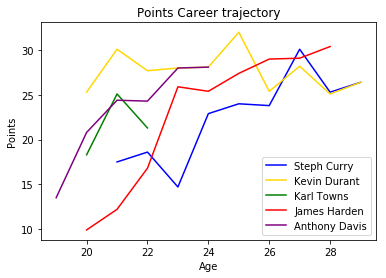

In [1268]:
plt.plot(df[df['player']=='Stephen Curry']['age'],df[df['player']=='Stephen Curry']['points'], color = 'blue',label = 'Steph Curry')
plt.plot(df[df['player']=='Kevin Durant']['age'],df[df['player']=='Kevin Durant']['points'], color = 'gold',label = 'Kevin Durant')
plt.plot(df[df['player']=='Karl-Anthony Towns']['age'],df[df['player']=='Karl-Anthony Towns']['points'], color = 'green',label = 'Karl Towns')
plt.plot(df[df['player']=='James Harden']['age'],df[df['player']=='James Harden']['points'], color = 'red',label = 'James Harden')
plt.plot(df[df['player']=='Anthony Davis']['age'],df[df['player']=='Anthony Davis']['points'], color = 'purple',label = 'Anthony Davis')

plt.title('Points Career trajectory')
plt.xlabel('Age')
plt.ylabel('Points')
plt.legend()

In [1277]:
df[(df['season']==2017) & (df['age']>30)]

,season,player,position,age,team,gamesPlayed,gamesStarted,minutes,points,rebounds,...,steals,blocks,turnovers,threes_made,FGM,FGA,FTM,FTA,starter,min_rank
4219,2017,LeBron James,PF,33.0,CLE,82,82,36.9,27.5,8.6,...,1.4,0.9,4.2,1.8,10.5,19.3,4.7,6.5,1,1
4232,2017,Taj Gibson,PF,32.0,MIN,82,82,33.2,12.2,7.1,...,0.8,0.7,1.1,0.1,5.2,9.0,1.7,2.3,1,14
4241,2017,Lou Williams,SG,31.0,LAC,79,19,32.8,22.6,2.5,...,1.1,0.2,3.0,2.4,7.4,16.9,5.5,6.2,0,23
4248,2017,LaMarcus Aldridge,C,32.0,SAS,75,75,33.5,23.1,8.5,...,0.6,1.2,1.5,0.4,9.2,18.0,4.5,5.3,1,30
4249,2017,Kyle Lowry,PG,31.0,TOR,78,78,32.2,16.2,5.6,...,1.1,0.2,2.3,3.1,5.2,12.1,2.9,3.3,1,31
4251,2017,Carmelo Anthony,PF,33.0,OKC,78,78,32.1,16.2,5.8,...,0.6,0.6,1.3,2.2,6.1,15.0,1.9,2.5,1,33
4254,2017,Dwight Howard,C,32.0,CHA,81,81,30.4,16.6,12.5,...,0.6,1.6,2.6,0.0,6.2,11.2,4.1,7.2,1,36
4261,2017,Marc Gasol,C,33.0,MEM,73,73,33.0,17.2,8.1,...,0.7,1.4,2.7,1.5,5.9,14.2,3.8,4.6,1,43
4263,2017,Goran Dragic,PG,31.0,MIA,75,75,31.7,17.3,4.1,...,0.8,0.2,2.2,1.5,6.5,14.3,2.9,3.6,1,45
4267,2017,Courtney Lee,SG,32.0,NYK,76,69,30.4,12.0,2.9,...,1.1,0.2,1.1,1.5,4.5,9.9,1.5,1.6,1,49


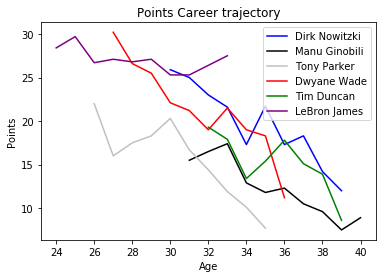

In [1295]:
players = ['Dirk Nowitzki','Manu Ginobili','Tony Parker','Dwyane Wade','Tim Duncan','LeBron James']
colors = ['blue','black','silver','red','green','purple']

for color,player in zip(colors,players):
    plt.plot(df[df['player']==player]['age'],df[df['player']==player]['points'], color = color,label = player)
    
plt.title('Points Career trajectory')
plt.xlabel('Age')
plt.ylabel('Points')
plt.legend()

In [1292]:
df[(df['season']==2012) &(df['team']=='MIA')][0:1]['player'].values

array(['LeBron James'], dtype=object)